<a href="https://colab.research.google.com/github/JericCantos/LoansClassifier/blob/main/Machine_Learning_Models_for_Loans_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We are given a dataset containing characteristics of what I assume to be loan applications which are labeled approved or declined.

It seems to ba a dataset that could be useful to train an ML model that can predict whether an application would / should be approved based on its features i.e. a binary classification problem.

# Flow:

1. Conducted data cleaning and EDA
  - split train and test after dropping duplicates and unlabeled rows.
  - Analyzed the distributions and correlations of the different dimensions, developed a few things to test for dimensionality reduction later.
2. Creted a data imputation, encoding, and scaling pipeline that I reused all throughout for consistency.
3. Determined what scoring function I would use based on the nature of the data: f1_weighted
4. Plotted the principal components vs. explained variance, determined number of components to test for PCA [4, 7, 10]
5. Created multiple variations of models:
  
| **Algorithms** | **Scoring Functions** | **Manually Dropped Column** | **PCA n_components** |
| ---------- | ------ | ------ | ----- |
| Logistic Regression | f1 | `dependents` | 4 |
| SVM | f1_weighted | `loan_amount` | 7 |
| Decision Tree | roc_auc | | 10 |
| Random Forest | | | |

  - Grid Search with Cross Validation was done for each variant.

# Results: Machine Learning Model Rankings

*Note: the "Minus Loan Amount" variants were done as after the rest of the models, so their summaries are listed separately.*

The best-performing model was the Vanilla SVM with the `loan_amount` removed, optimizing for roc_auc, beating out every other model slightly in f1_weighted score, and is in 2nd place in terms of roc_auc.

Prior to the `loan_amount` modeels, the random forest models with small `min_samples_split` and `min_samples_leaf` parameters performed very slightly better than the next-best model (Logistic Regression using any scoring function) according to my chosen scoring criteria - weighted F1-score > roc_auc.
Random Forests with small samples minus the dependents column optimized for roc_auc score is tied with them.

Logistic Regression has a slightly higher F1 score than the best models, which means it is a bit better at predicting class 1, but slightly worse at predicting class 0.


---



**Given the vast difference between the time required to train and execute these models, and the potential need to explain why the models performed the way they did, I am inclined to use Logistic Regression overall.**

## Jeric's Choice: Logistic Regresssion Minus Dependents using Weighted F1-score

[Logistic Regression Minus Dependents](#scrollTo=TEOKtKeQVzs9)

I choose this as the preferred model because:
- It performs comparably with the "Best" model
  - only 0.61% lower f1_weighted, but 0.36% higher f1 sccore i.e. better at predicting class 1, worse at predicting class 0.
- It is more easily explainable. I can extract the weights of each dimension and say which ones impacted the assessment most heavily.
- Reduced the dimensions of the full dataset without impacting performance, making it less complex than leaving the dataset as is.
- Because it "errs on the side of class 1", I think it has more of a "heart" when it comes to loan applications.




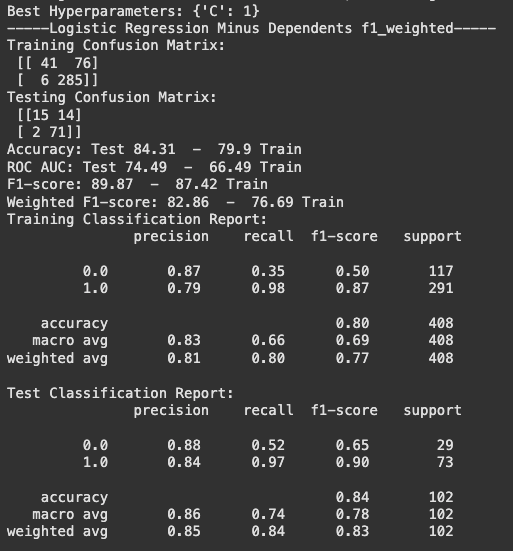

## "Minus Loan Amount" Models

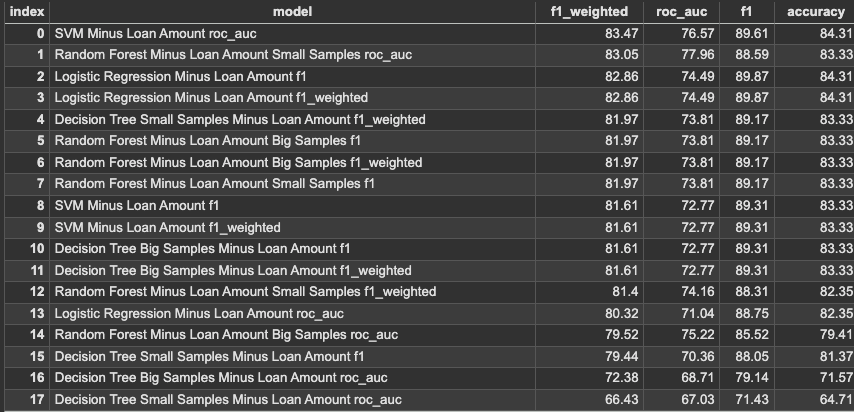

## Main Models

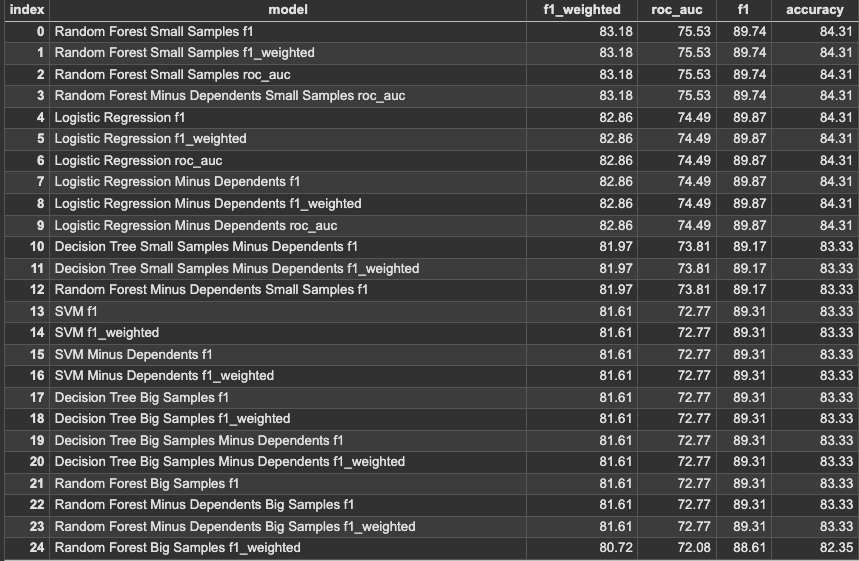

# Data Dictionary

| Column Name |	Description | Comment |
| ----------- | ------------ | ------------ |
| loan_id	| Unique loan ID | Probably drop this for analysis, <br> loan_id should not impact approval. <br> Other option is to make it an index? |
| gender	| Gender <br> Male / Female | Male 0 / Female 1 |
| married	| Marital status <br> Yes / No | Yes 1/ No. 0 |
| dependents	| Number of dependents | Apparently not integers. Can be: 0, 1, 2, 3+ <br> if I assume 4 or 5 dependents is treated as 3, <br> I can encode them just as integers 0, 1, 2, 3 |
|
| education	| Education <br> Graduate / Not Graduate | Graduate 1  / Not Graduate 0 |
| self_employed	| Self-employment status <br> Yes / No | Yes 1/ No. 0 |
| applicant_income	| Applicant's income |
| coapplicant_income	| Coapplicant's income |
| loan_amount	| Loan amount (thousands) |
| loan_amount_term	| Term of loan (months) | hunch is there's a huge difference <br> between a 1-month loan and a 360-month loan.  <br> I would first go with ordinal encoding |
| credit_history	| Credit history meets guidelines <br> 1 / 0 |
| property_area	| Area of the property <br> Urban / Semi Urban / Rural | One-Hot Encode
| loan_status	| Loan approval status (target) <br> 1 / 0 |

# Important Prerequisites


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, \
    classification_report, roc_auc_score, f1_score
from scipy.stats import chi2_contingency

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


## Load Dataset

In [ ]:
#https://drive.google.com/file/d/1yBwpPsPsp1AZGDv_VdGSv1Lov2RwtbN2/view

file_id = "1yBwpPsPsp1AZGDv_VdGSv1Lov2RwtbN2"
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

response = requests.get(download_url)
if response.status_code == 200:
    csv_data = StringIO(response.text)
    df = pd.read_csv(csv_data)
    print(df.head())
else:
    print("Failed to download the file.")

    loan_id gender married dependents     education self_employed  \
0  LP001003   Male     Yes          1      Graduate            No   
1  LP001005   Male     Yes          0      Graduate           NaN   
2  LP001006   Male     Yes          0  Not Graduate            No   
3  LP001008   Male      No          0      Graduate            No   
4  LP001011   Male     Yes          2      Graduate           Yes   

   applicant_income  coapplicant_income  loan_amount  loan_amount_term  \
0            4583.0              1508.0        128.0             360.0   
1            3000.0                 0.0         66.0             360.0   
2            2583.0              2358.0        120.0             360.0   
3            6000.0                 0.0        141.0             360.0   
4            5417.0              4196.0        267.0             360.0   

   credit_history property_area  loan_status  
0             1.0         Rural          0.0  
1             1.0         Urban          1.0  

# EDA

## Handle Duplicates

In [ ]:
#full duplicates
print (df.duplicated().sum())

25


In [ ]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(563, 13)
(538, 13)


## Handle Nulls

In [ ]:
df.describe()

applicant_income  coapplicant_income  loan_amount  loan_amount_term  \
count        514.000000          506.000000   508.000000        513.000000   
mean        5384.842412         1708.705375   147.840551        341.590643   
std         6141.985258         3148.027455    86.277271         65.391340   
min          150.000000            0.000000     9.000000         12.000000   
25%         2890.250000            0.000000   100.000000        360.000000   
50%         3768.500000         1250.000000   128.000000        360.000000   
75%         5817.250000         2335.250000   172.000000        360.000000   
max        81000.000000        41667.000000   650.000000        480.000000   

       credit_history  loan_status  
count      516.000000   510.000000  
mean         0.874031     0.713725  
std          0.332136     0.452463  
min          0.000000     0.000000  
25%          1.000000     0.000000  
50%          1.000000     1.000000  
75%          1.000000     1.000000  
max          1.000000     1.000000

In [ ]:
df.isnull().sum()

loan_id               26
gender                27
married               19
dependents            30
education             21
self_employed         32
applicant_income      24
coapplicant_income    32
loan_amount           30
loan_amount_term      25
credit_history        22
property_area         20
loan_status           28
dtype: int64

In [ ]:
df.isnull().sum().sum()

np.int64(336)

There seem to be quite a few nulls. Loan ID can be removed, that would still mean there's a maximum of 325 rows that may be deleted if we decide to drop nulls.

If I decide to make loan_id an index, I would need to fill-in the nulls somehow with unique entries, or drop the rows with nulls. I will go with the simple approach first of just dropping the column for analysis and training.

In [ ]:
df_copy = df.copy()
del df_copy['loan_id']
df_copy = df_copy.dropna()
rows_lost = len(df) - len(df_copy)
print (f'Rows Lost: {rows_lost}')

print (df.shape, df_copy.shape)

Rows Lost: 248
(538, 13) (290, 12)


We are losing too many rows in our dataset for us to simply drop all rows with nulls. Since I don't know how important each variable may be to the prediction, I don't feel confident in simply dropping the columns.

I would then proceed with:
1. dropping the rows where loan_status (target) is null
2. imputing the nulls for each other column.

In [ ]:
#drop the ID
df_labeled = df.iloc[:, 1:]
print (df.shape, df_labeled.shape)
df_labeled.head()

(538, 13) (538, 12)


gender married dependents     education self_employed  applicant_income  \
0   Male     Yes          1      Graduate            No            4583.0   
1   Male     Yes          0      Graduate           NaN            3000.0   
2   Male     Yes          0  Not Graduate            No            2583.0   
3   Male      No          0      Graduate            No            6000.0   
4   Male     Yes          2      Graduate           Yes            5417.0   

   coapplicant_income  loan_amount  loan_amount_term  credit_history  \
0              1508.0        128.0             360.0             1.0   
1                 0.0         66.0             360.0             1.0   
2              2358.0        120.0             360.0             1.0   
3                 0.0        141.0             360.0             1.0   
4              4196.0        267.0             360.0             1.0   

  property_area  loan_status  
0         Rural          0.0  
1         Urban          1.0  
2         Urban          1.0  
3         Urban          1.0  
4         Urban          1.0

In [ ]:
df_labeled = df_labeled[(~df_labeled['loan_status'].isnull())]

print(df.shape,  df_labeled.shape)
print(f"Rows Lost: {len(df) - len(df_labeled)}")
df_labeled.isnull().sum()

(538, 13) (510, 12)
Rows Lost: 28


gender                23
married               19
dependents            29
education             20
self_employed         32
applicant_income      24
coapplicant_income    31
loan_amount           30
loan_amount_term      25
credit_history        20
property_area         19
loan_status            0
dtype: int64

In [ ]:
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 0 to 536
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              487 non-null    object 
 1   married             491 non-null    object 
 2   dependents          481 non-null    object 
 3   education           490 non-null    object 
 4   self_employed       478 non-null    object 
 5   applicant_income    486 non-null    float64
 6   coapplicant_income  479 non-null    float64
 7   loan_amount         480 non-null    float64
 8   loan_amount_term    485 non-null    float64
 9   credit_history      490 non-null    float64
 10  property_area       491 non-null    object 
 11  loan_status         510 non-null    float64
dtypes: float64(6), object(6)
memory usage: 51.8+ KB


In [ ]:
for column in df_labeled.columns:
  if df_labeled[column].dtype != 'float64':
    print (column, df_labeled[column].unique())



gender ['Male' 'Female' nan]
married ['Yes' 'No' nan]
dependents ['1' '0' '2' '3+' nan]
education ['Graduate' 'Not Graduate' nan]
self_employed ['No' nan 'Yes']
property_area ['Rural' 'Urban' nan 'Semiurban']


No misspellings or trailing spaces, so I don't need to sanitize the data before encoding at least.

(QQQ) Number of dependents is tricky. Am I able to simply replace 3+ with 3 and convert this to integer values? I think I will choose to do so first and see how the models behave. If time permits, I may try one-hot encoding for this column instead.

(QQQ) loan_amount_term is numeric, but it looks to be specific categories that are pretty regular and whole numbered. They all seem to be divisible by 12 i.e. number of years to repay your loan (except for 1-month loans). Would it be better to encode this? My guess is yes, since I am not assuming that 36 months has 3x the effect as 12 months on the data. However, I am not certain if I should use ordinal enncoding, one-hot encoding, or or leave it as is i.e. integer values. I have used ordinal encoding so far.

(QQQ) credit history: my gut tells me this variable may have a big effect on getting a loan approved. Is it then advisable to impute it? Or simply drop the columns with null values? ---> proven to have a high correlation later

## Train Test Split

In [ ]:
  X = df_labeled.drop(['loan_status'], axis=1)
  y = df_labeled['loan_status']

  # stratify the data to account for the imbalance
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, stratify=y, test_size=0.2, random_state=42)

  print (len(X_train), len(y_train))
  print (len(X_test), len(y_test))

408 408
102 102


### Imputation

There's no identifying data for each row that will help me figure out a better imputation grouping, so I will just impute the nulls using the entire dataset.

In [ ]:
# Mode for credit_history
# Mode for loan_amount_term
# Mode for string columns
# Median for other float columns
# - I noticed that the applicant_income, coapplicant_income, and loan_amount
#   had a lot of outliers which might distort the mean.

imputation_dict = {} # save the values for imputation of new data

mode_credit_history = X_train['credit_history'].mode()[0]
X_train.fillna({'credit_history': mode_credit_history}, inplace=True)
imputation_dict['credit_history'] = mode_credit_history

mode_loan_amount_term = X_train['loan_amount_term'].mode()[0]
X_train.fillna({'loan_amount_term': mode_credit_history}, inplace=True)
imputation_dict['loan_amount_term'] = mode_loan_amount_term

for column in X_train.columns:
  if X_train[column].dtype != 'float64':
    mode_string = X_train[column].mode()[0]
    X_train.fillna({column:mode_string}, inplace=True)
    imputation_dict[column] = mode_string
  else:
    median_num = X_train[column].median()
    X_train.fillna({column:median_num}, inplace=True)
    imputation_dict[column] = median_num


for column in X_train.columns:
  if X_train[column].dtype != 'float64':
    print (column, X_train[column].unique())

print('loan_amount_term', X_train['loan_amount_term'].unique())

X_train.isnull().sum()

gender ['Male' 'Female']
married ['Yes' 'No']
dependents ['0' '1' '3+' '2']
education ['Graduate' 'Not Graduate']
self_employed ['No' 'Yes']
property_area ['Semiurban' 'Urban' 'Rural']
loan_amount_term [360. 480. 300. 180.   1.  36.  84. 120. 240.  60.  12.]


gender                0
married               0
dependents            0
education             0
self_employed         0
applicant_income      0
coapplicant_income    0
loan_amount           0
loan_amount_term      0
credit_history        0
property_area         0
dtype: int64

In [ ]:
imputation_dict

{'credit_history': 1.0,
 'loan_amount_term': 360.0,
 'gender': 'Male',
 'married': 'Yes',
 'dependents': '0',
 'education': 'Graduate',
 'self_employed': 'No',
 'applicant_income': 3867.0,
 'coapplicant_income': 1250.0,
 'loan_amount': 128.0,
 'property_area': 'Semiurban'}

## Parameter Distributions

We have very skewed categorical data.

If this model will be used in the real world, I believe there should be something done in order to reduce the bias, especially since Gender annd Education are used as predictors. However, I have not yet encountered such tools in the learning materials.

I will implement stratified sampling due to the imbalance in the target column.

In [ ]:
categorical_columns = ['gender', 'education', 'married',
                      'self_employed', 'credit_history',
                       'loan_amount_term', 'dependents',
                       'property_area']

print (y_train.value_counts(normalize=True))
for column in categorical_columns:
  print (X_train[column].value_counts(normalize=True))

loan_status
1.0    0.713235
0.0    0.286765
Name: proportion, dtype: float64
gender
Male      0.835784
Female    0.164216
Name: proportion, dtype: float64
education
Graduate        0.779412
Not Graduate    0.220588
Name: proportion, dtype: float64
married
Yes    0.661765
No     0.338235
Name: proportion, dtype: float64
self_employed
No     0.865196
Yes    0.134804
Name: proportion, dtype: float64
credit_history
1.0    0.889706
0.0    0.110294
Name: proportion, dtype: float64
loan_amount_term
360.0    0.806373
180.0    0.068627
1.0      0.049020
480.0    0.024510
300.0    0.019608
84.0     0.007353
120.0    0.007353
36.0     0.004902
240.0    0.004902
60.0     0.004902
12.0     0.002451
Name: proportion, dtype: float64
dependents
0     0.575980
2     0.178922
1     0.166667
3+    0.078431
Name: proportion, dtype: float64
property_area
Semiurban    0.389706
Urban        0.313725
Rural        0.296569
Name: proportion, dtype: float64


In [ ]:
X_train.describe()

applicant_income  coapplicant_income  loan_amount  loan_amount_term  \
count        408.000000          408.000000   408.000000        408.000000   
mean        5480.004902         1664.853235   145.132353        323.519608   
std         6432.024442         2733.520038    80.854631         99.825768   
min          150.000000            0.000000     9.000000          1.000000   
25%         3009.750000            0.000000   100.000000        360.000000   
50%         3867.000000         1250.000000   128.000000        360.000000   
75%         5731.000000         2250.750000   165.250000        360.000000   
max        81000.000000        33837.000000   650.000000        480.000000   

       credit_history  
count      408.000000  
mean         0.889706  
std          0.313641  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000

Incomes (applicant and coapplicant) and loan amounts seem to have quite long tails to the right

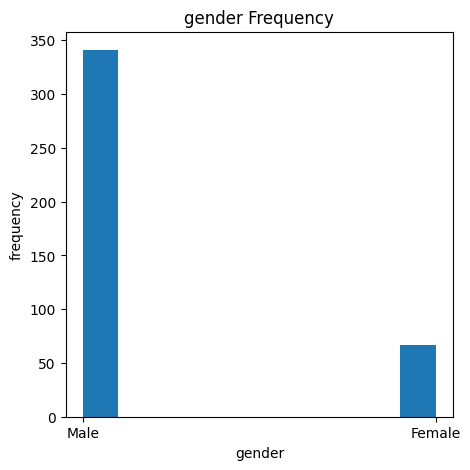

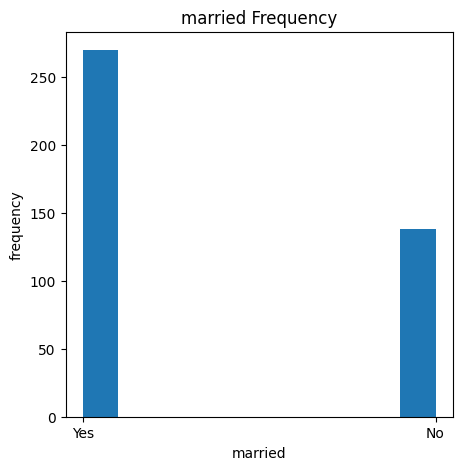

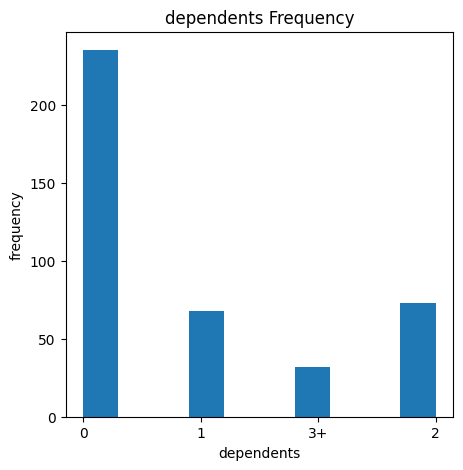

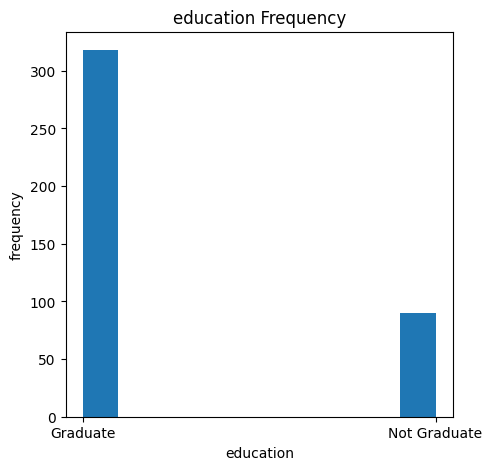

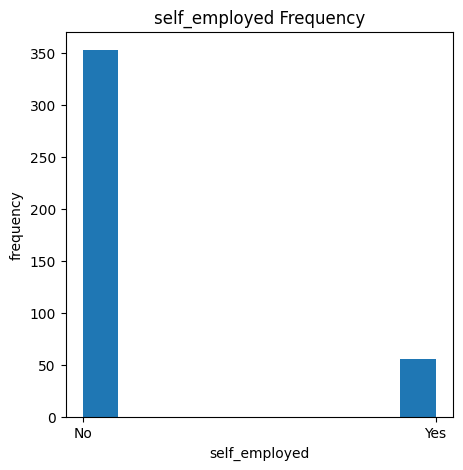

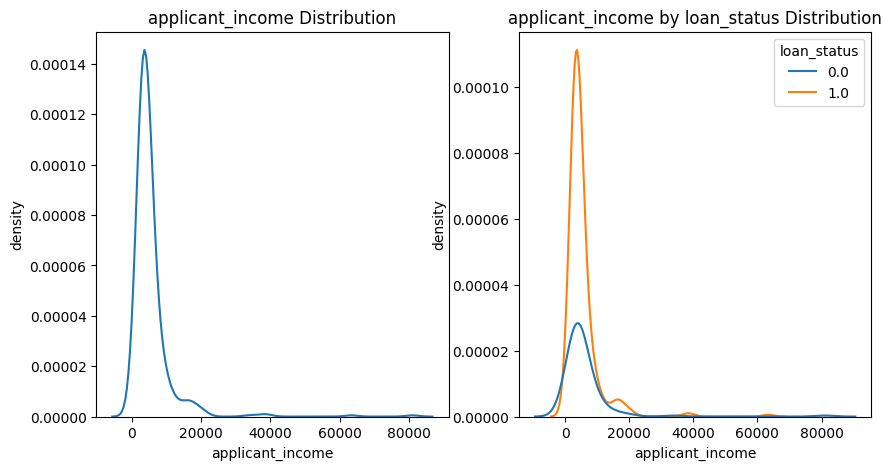

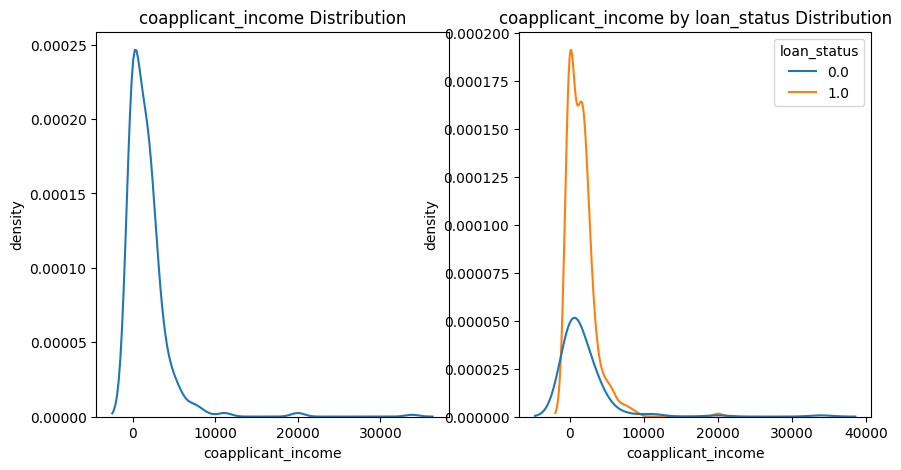

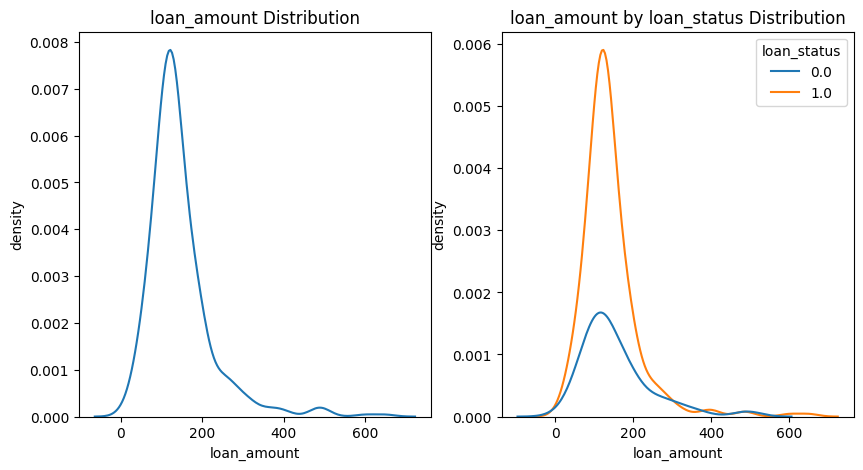

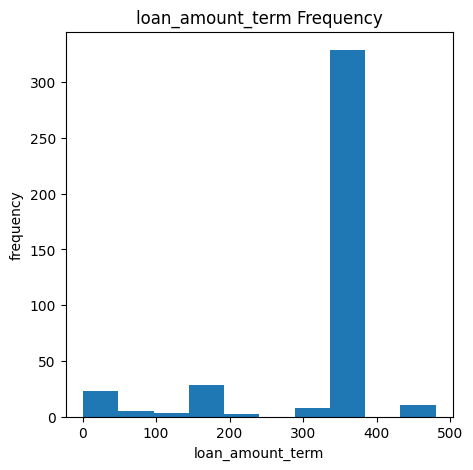

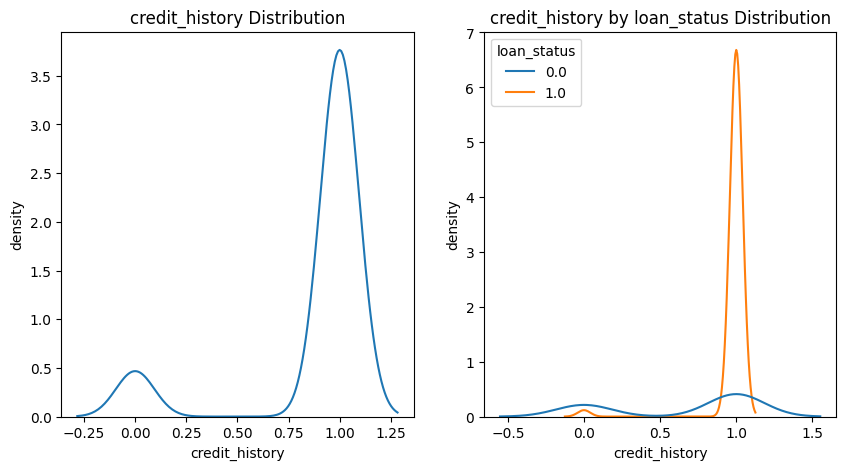

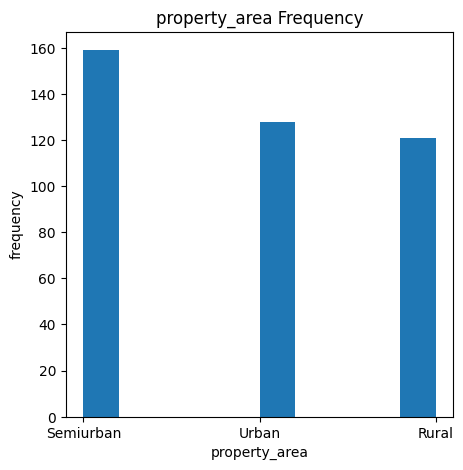

In [ ]:
for column in X_train.columns:
  if (column == 'loan_amount_term'):
    plt.figure(figsize=(5, 5))
    plt.hist(X_train[column])
    plt.title(f"{column} Frequency")
    plt.xlabel(column)
    plt.ylabel("frequency")
    plt.show()
  elif df_labeled[column].dtype != 'float64':
    plt.figure(figsize=(5, 5))
    plt.hist(X_train[column])
    plt.title(f"{column} Frequency")
    plt.xlabel(column)
    plt.ylabel("frequency")
    plt.show()
  else:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    sns.kdeplot(x=X_train[column], bw_adjust=1, ax=ax1)
    ax1.set_title(f"{column} Distribution")
    ax1.set_xlabel(column)
    ax1.set_ylabel("density")

    sns.kdeplot(x=X_train[column], bw_adjust=1,
                hue=y_train, ax=ax2)
    ax2.set_title(f"{column} by loan_status Distribution")
    ax2.set_xlabel(column)
    ax2.set_ylabel("density")
    plt.show()

After seeing the density plots, the income and loan variables don't as much seem to have a long tail, as they do have quite drastic outliers. Will try to confirm with box plots.

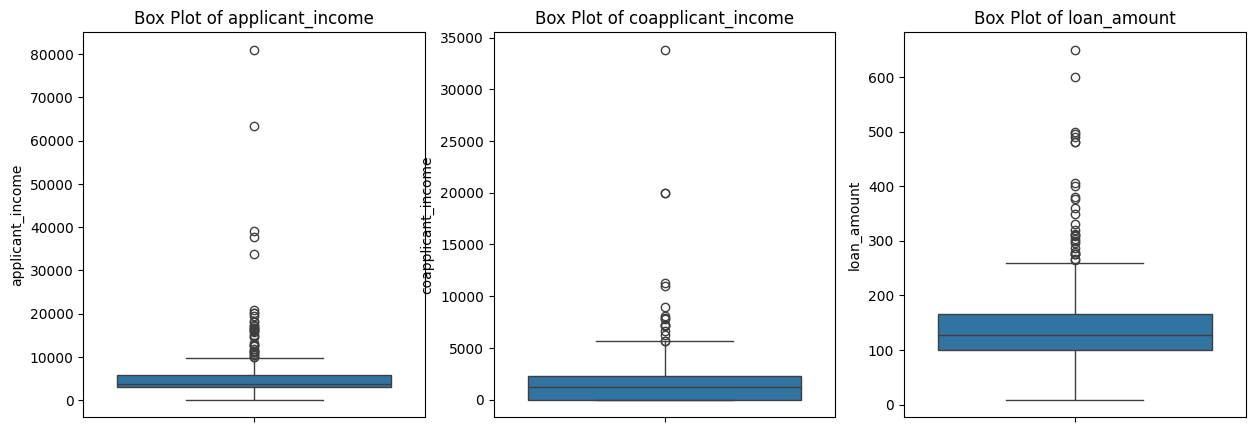

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1, ax2, ax3 = axes.flatten()
ax_array = [ax1, ax2, ax3]
i = 0
for column in X_train.columns:
  if (X_train[column].dtype == 'float64' and \
      column not in ['credit_history', 'loan_amount_term']) :
    ax = ax_array[i]
    i+=1
    sns.boxplot(y=X_train[column], ax=ax)
    ax.set_title(f"Box Plot of {column}")

plt.show()

Tons of outliers on beyond the maximum whisker. I would want to use robust scaling on the dataset, especially since the values of each continuous feature are orders of magnitude apart.

Need to scale only these continuous columns and ensure that the other columns are not affected.

##Correlations

Also from the density plots, credit history seems to be a very strong predictor of loan approval, with such a big spike. What about the other categorical data?

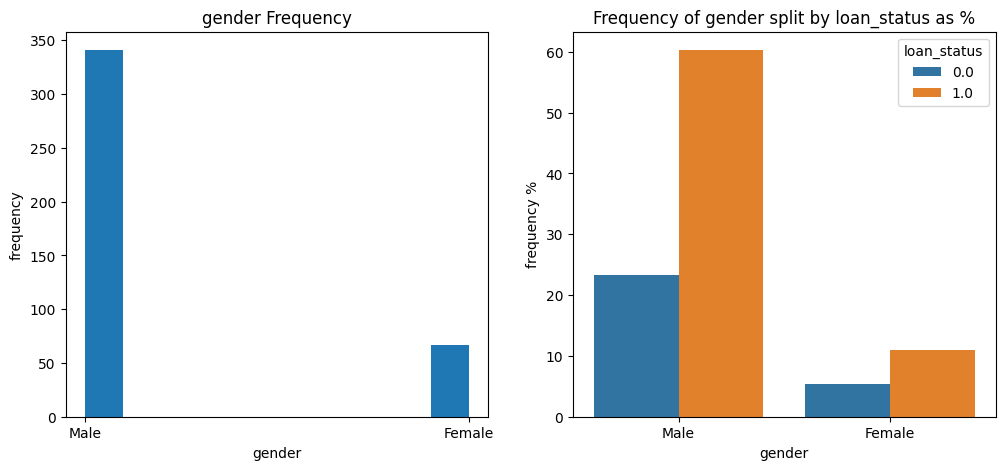

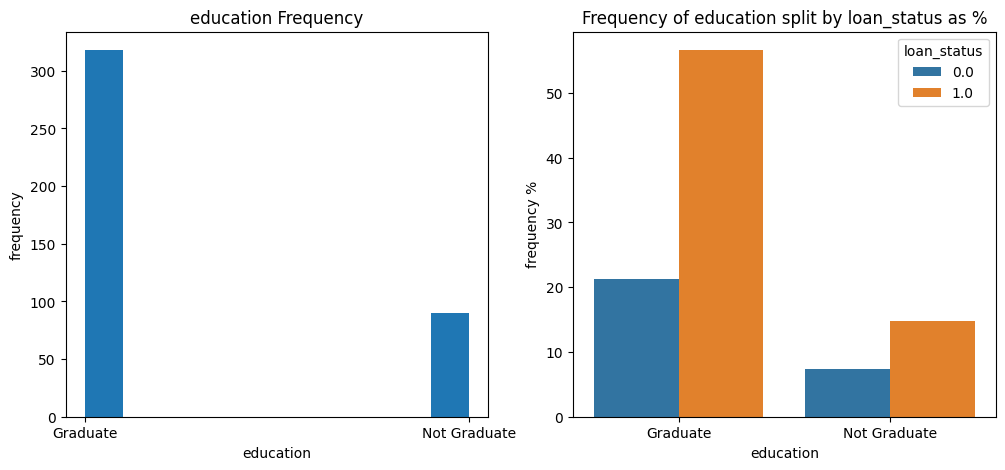

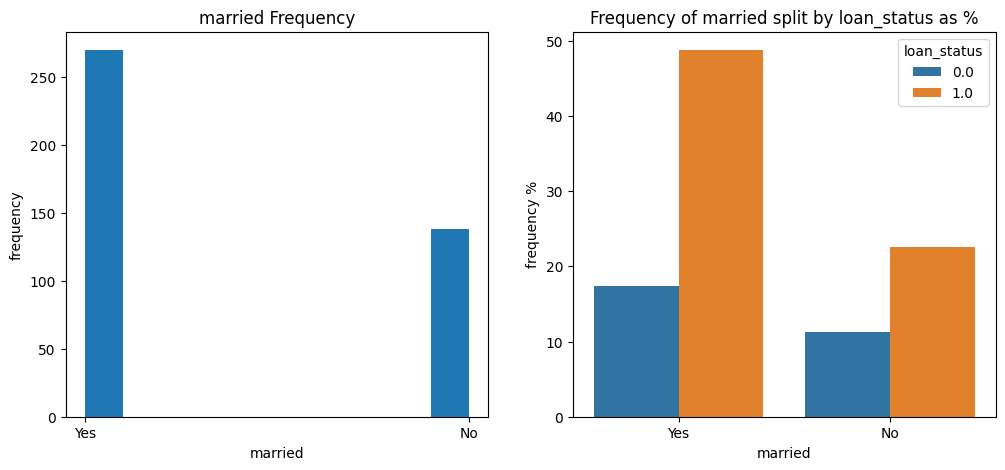

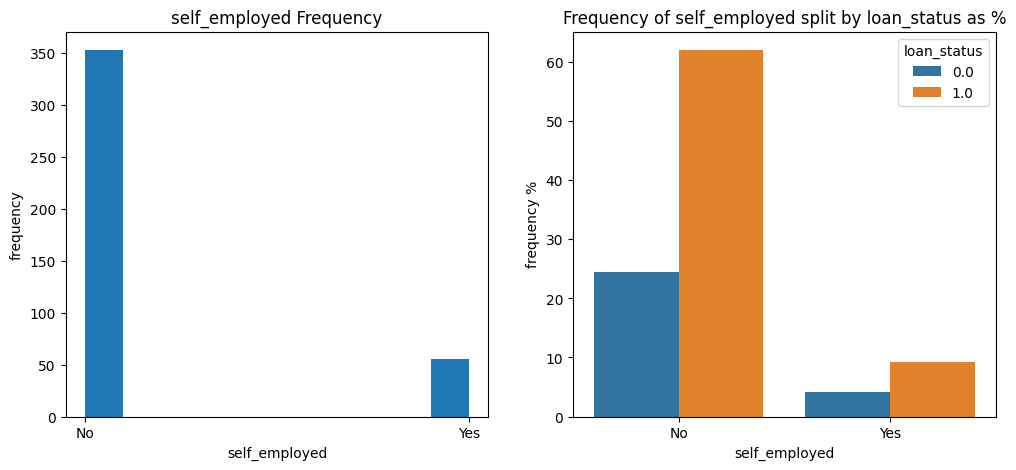

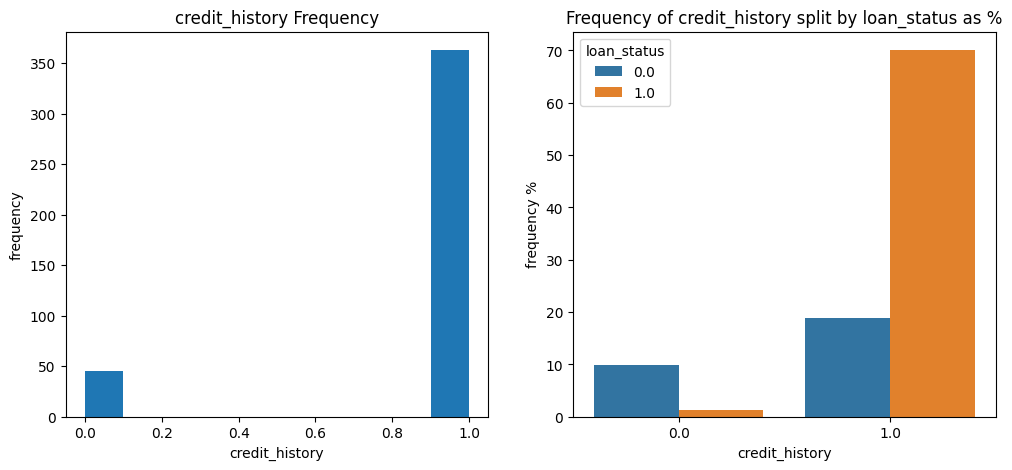

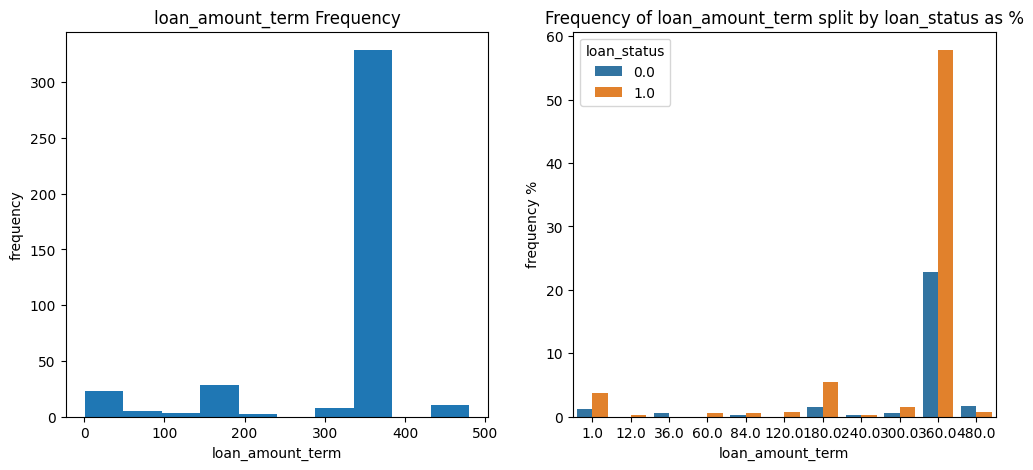

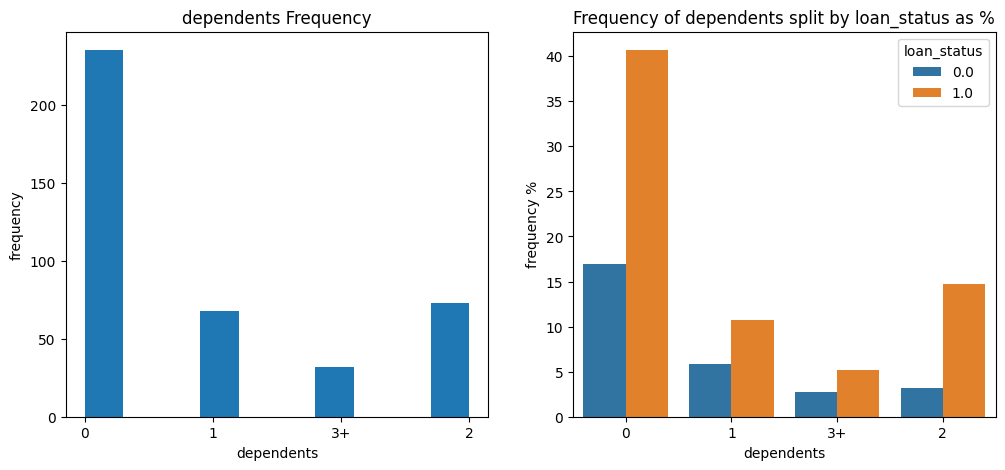

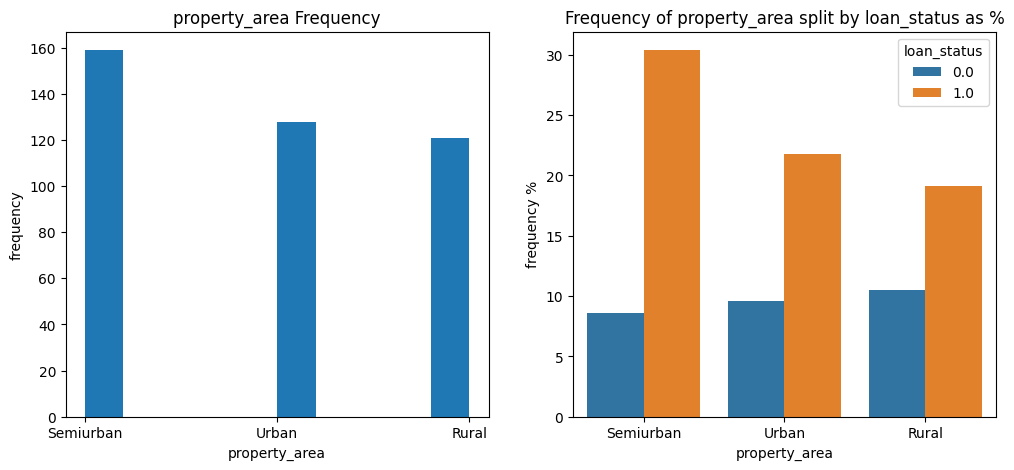

In [ ]:
for column in categorical_columns:
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

  ax1.hist(X_train[column])
  ax1.set_title(f"{column} Frequency")
  ax1.set_xlabel(column)
  ax1.set_ylabel("frequency")

  sns.countplot(data=X_train, x=column, hue=y_train,
                stat='percent', ax=ax2, )
  ax2.set_title (f'Frequency of {column} split by loan_status as %')
  ax2.set_xlabel(column)
  ax2.set_ylabel("frequency %")

  plt.show()

Aside from credit history, the only other feature I saw where a loan is more likely to be declined based on a particular result would be the 36-month and 480-month loans. 12-, 60-, and 120-month loans seem to be all approveed. But the proportion of the data is too small that it warrants a closer look.

In [ ]:
loans_table = X_train.loc[(X_train.loan_amount_term == 36.0) |
                (X_train.loan_amount_term == 480.0) |
                (X_train.loan_amount_term == 12.0) |
                (X_train.loan_amount_term == 60.0) |
                (X_train.loan_amount_term == 120.0)
                ]

cross_tab = pd.crosstab(loans_table.loan_amount_term,
                        y_train.loc[loans_table.index])
print(cross_tab)

loan_status       0.0  1.0
loan_amount_term          
12.0                0    1
36.0                2    0
60.0                0    2
120.0               0    3
480.0               7    3


The sample sizes for each loan_amount_term are really very small. No 36-month loan was approved (2 instances), and approval for 480-month loans is at 30% (3 approved out of 10 total).

The rest havve 100% approval but only 1-3 samples.

### Continuous Data

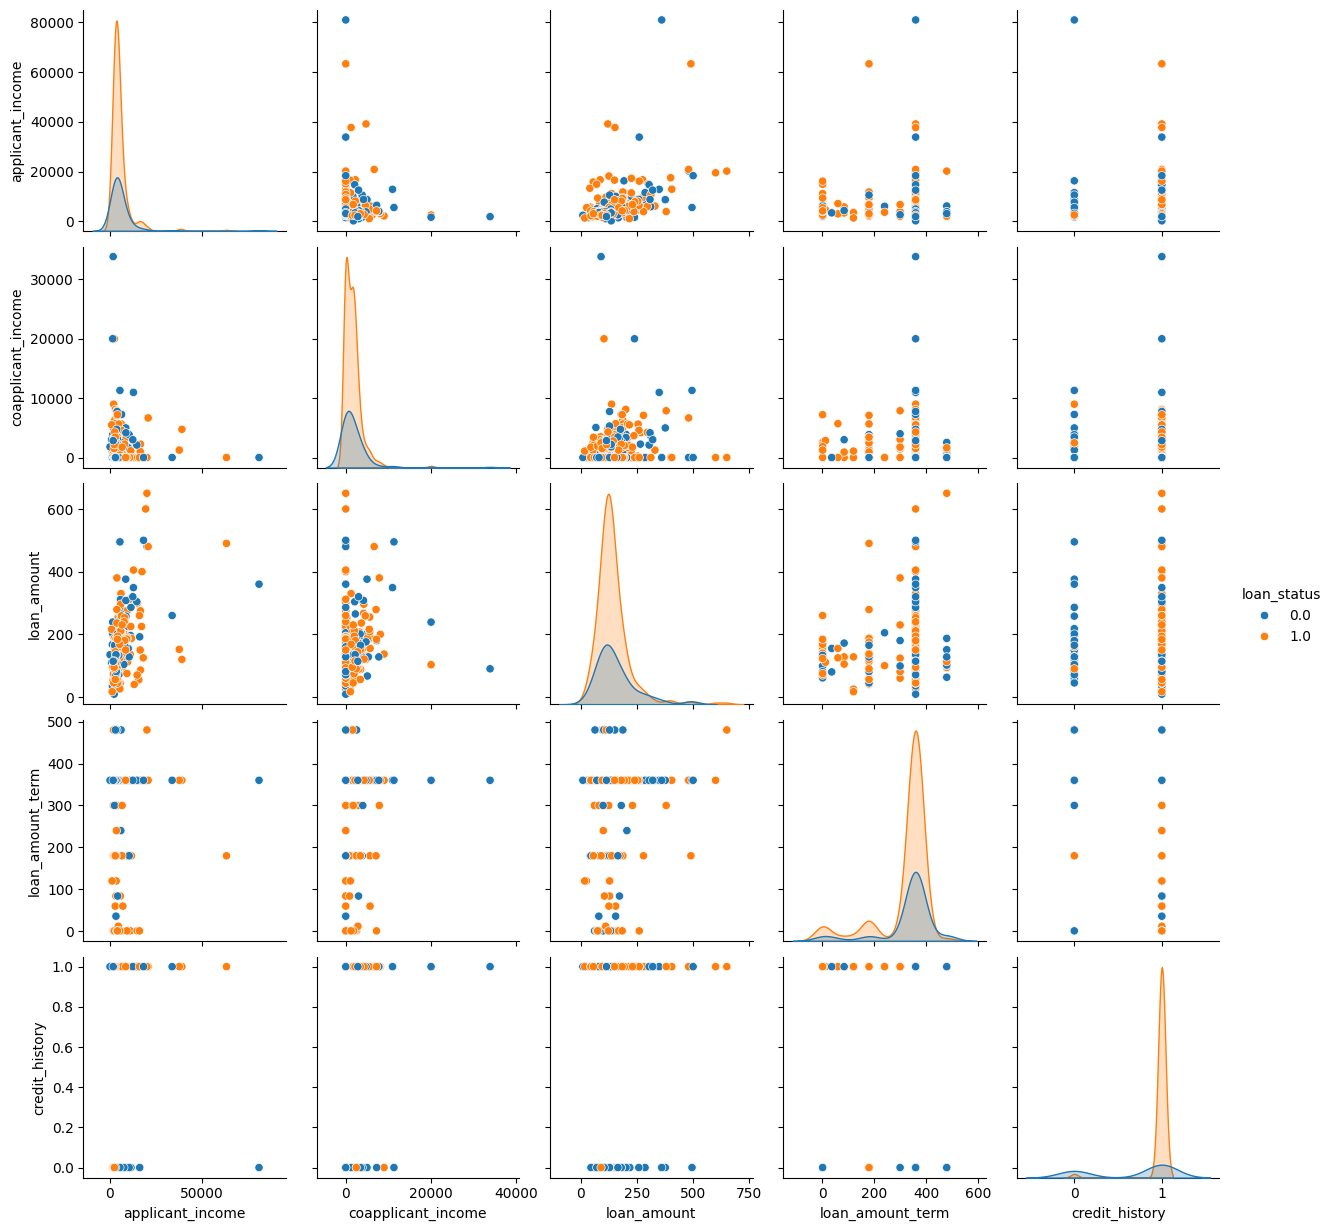

In [ ]:
#re stack X_train and y_train temporarily for a pairplot
X_train_stacked = X_train.copy()
X_train_stacked['loan_status'] = y_train

sns.pairplot(X_train_stacked, hue='loan_status')

Eye test on these pairplots:
- Applicant and coapplicant incomes seem to have an inverse relationship
- Applicant and coapplicant incomes seem to have a a slight positive relationship with loan amount, but it is so slight especially for coapplicant income that I am not sure.

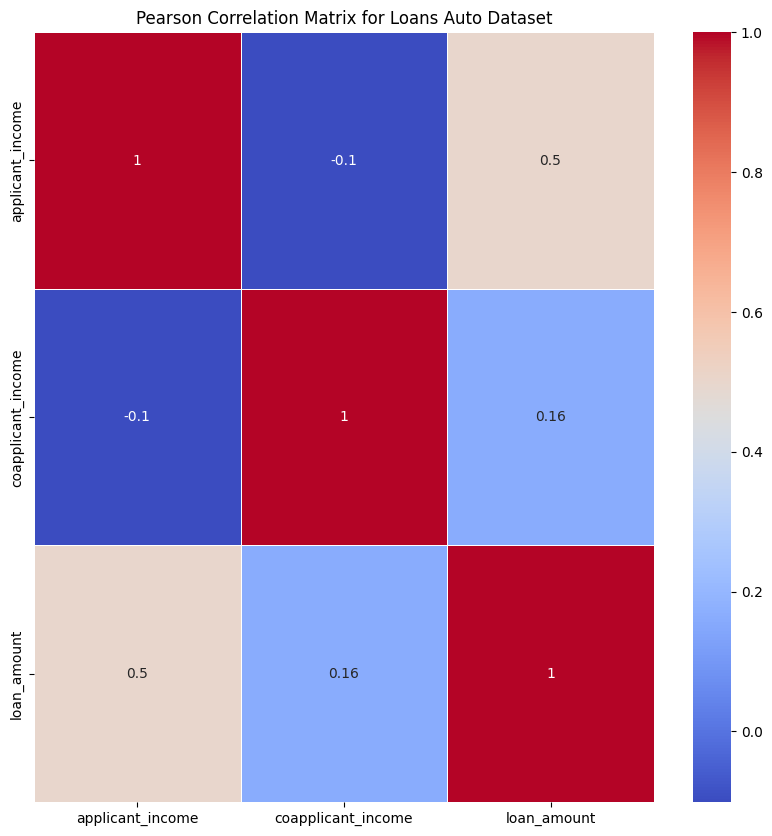

In [ ]:
numerical_data = X_train.drop(categorical_columns, axis=1)

correlation_matrix = numerical_data.corr(method='pearson')

plt.figure(figsize=(10,10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5
)

plt.title('Pearson Correlation Matrix for Loans Auto Dataset')
plt.show()

Data has a bunch of outliers, but I still wanted to see what Pearson would detect.

- weak negative correlation between applicant and coapplicant income.
- weak positive correlation between coapplicant income and loan amount
- moderate positive correlation between applicant income and loan amount.

Seems to match my eye test.

### Categorical Data

Mapping direclty to the target `loan_status`, there seem to be a couple of other categorical variables with statistically significant associations aside from `credit_history` which we already identified:
- `married`
- `property_area`


There seem to be statistically significant relationships between:
- `gender` and `married`
- `gender` and `dependents`
- `married` and `dependents`


In [ ]:
categories = categorical_columns.copy()
categories.append('loan_status')

chi2_dict = {'column1': [],
             'column2': [],
             'chi2' : [],
             'p' : [],
             'dof' : [],
             }

for category in categories:
  for category2 in categories:
    if (category == category2 or category2 in chi2_dict['column1']):
      continue
    contingency_table = pd.crosstab(X_train_stacked[category], X_train_stacked[category2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    chi2_dict['column1'].append(category)
    chi2_dict['column2'].append(category2)
    chi2_dict['chi2'].append(chi2)
    chi2_dict['dof'].append(dof)
    chi2_dict['p'].append(p)


In [ ]:
df_chi2 = pd.DataFrame(data=chi2_dict)

#df_related = df_chi2
df_related = df_chi2.loc[(df_chi2['p'] < 0.05)]



df_related

column1           column2       chi2             p  dof
1           gender           married  45.337405  1.658511e-11    1
5           gender        dependents  14.927904  1.879308e-03    3
17         married  loan_amount_term  19.244876  3.726038e-02   10
18         married        dependents  47.696381  2.471043e-10    3
29  credit_history       loan_status  86.377713  1.486508e-20    1
35   property_area       loan_status   6.437841  3.999822e-02    2

Hunches:
- if we reduce dimensions manually, perhaps we can drop `dependents` since it is already significantly related to `gender`
- `married` has a significant relationship with the target, so I don't want to drop it.
- at a lower priority, could `loan_amount` be dropped in favor of just keeping `applicant_income`?

# Cleaning and Encoding Pipeline
From: Data Dictionary


| Column Name |	Description | Comment |
| ----------- | ------------ | ------------ |
| gender	| Gender <br> Male / Female | Male 0 / Female 1 |
| married	| Marital status <br> Yes / No | Yes 1/ No. 0 |
| dependents	| Number of dependents | Apparently not integers. Can be: 0, 1, 2, 3+ <br> if I assume 4 or 5 dependents is treated as 3, <br> I can encode them just as integers 0, 1, 2, 3 |
|
| education	| Education <br> Graduate / Not Graduate | Graduate 1  / Not Graduate 0 |
| self_employed	| Self-employment status <br> Yes / No | Yes 1/ No. 0 |
| loan_amount_term	| Term of loan (months) | hunch is there's a huge difference <br> between a 1-month loan and a 360-month loan.  <br> I would first go with ordinal encoding |
| credit_history	| Credit history meets guidelines <br> 1 / 0 |
| property_area	| Area of the property <br> Urban / Semi Urban / Rural | One-Hot Encode
| loan_status	| Loan approval status (target) <br> 1 / 0 |


- since I one-hot encoded the `property_area`, I am dropping `property_area_Rural` for Logistic Regression and SVM to avoid multicolinearity, but I am keeping it for the Tree-Based models which shouldn't be affected.

In [ ]:
# transform the dependents column to int.
# Ensure this is done whenever we transform e.g. x_test or new data
X_train['dependents'] = X_train['dependents'].\
                              apply(lambda x: int(str(x).replace('+','')))

# separate categorical columns by conding
cat_label_columns = ['gender', 'education', 'married',
                      'self_employed', 'credit_history',
                    ]

cat_ordinal_columns = ['loan_amount_term', 'dependents']

cat_one_hot_columns = ['property_area']


num_columns = ['applicant_income', 'coapplicant_income', 'loan_amount']


In [ ]:
# Define Transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
    #apply RobustScaler because the data has a lot of outliers
])

cat_label_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('labeler', OrdinalEncoder())
    #using ordinal encoder because LabelEncoder does not work with pipelines
])

cat_ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])


cat_onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_columns),
        ('cat_label', cat_label_transformer, cat_label_columns),
        ('cat_ord', cat_ordinal_transformer, cat_ordinal_columns),
        ('cat_onehot', cat_onehot_transformer, cat_one_hot_columns),
    ])

In [ ]:
X_train_scaled = preprocessor.fit_transform(X_train)
df_train_scaled= pd.DataFrame(X_train_scaled, columns=preprocessor.get_feature_names_out())
df_train_scaled.head()

num__applicant_income  num__coapplicant_income  num__loan_amount  \
0               1.916766                -0.555370          1.532567   
1               4.550482                -0.555370          0.980843   
2               0.000000                 0.888593          0.459770   
3              -0.664033                 0.426080          0.091954   
4               0.875701                 0.000000          0.000000   

   cat_label__gender  cat_label__education  cat_label__married  \
0                1.0                   0.0                 1.0   
1                1.0                   0.0                 0.0   
2                1.0                   0.0                 1.0   
3                1.0                   0.0                 0.0   
4                1.0                   0.0                 1.0   

   cat_label__self_employed  cat_label__credit_history  \
0                       0.0                        1.0   
1                       1.0                        0.0   
2                       0.0                        1.0   
3                       0.0                        1.0   
4                       0.0                        1.0   

   cat_ord__loan_amount_term  cat_ord__dependents  \
0                        9.0                  0.0   
1                        9.0                  0.0   
2                        9.0                  1.0   
3                        9.0                  0.0   
4                        9.0                  0.0   

   cat_onehot__property_area_Rural  cat_onehot__property_area_Semiurban  \
0                              0.0                                  1.0   
1                              0.0                                  0.0   
2                              0.0                                  0.0   
3                              0.0                                  1.0   
4                              0.0                                  1.0   

   cat_onehot__property_area_Urban  
0                              0.0  
1                              1.0  
2                              1.0  
3                              0.0  
4                              0.0

In [ ]:
X_train.head()

gender married  dependents education self_employed  applicant_income  \
301   Male     Yes           0  Graduate            No            9083.0   
217   Male      No           0  Graduate           Yes           16250.0   
482   Male     Yes           1  Graduate            No            3867.0   
224   Male      No           0  Graduate            No            2060.0   
192   Male     Yes           0  Graduate            No            6250.0   

     coapplicant_income  loan_amount  loan_amount_term  credit_history  \
301                 0.0        228.0             360.0             1.0   
217                 0.0        192.0             360.0             0.0   
482              3250.0        158.0             360.0             1.0   
224              2209.0        134.0             360.0             1.0   
192              1250.0        128.0             360.0             1.0   

    property_area  
301     Semiurban  
217         Urban  
482         Urban  
224     Semiurban  
192     Semiurban

In [ ]:
print (X_train.groupby('loan_amount_term')['loan_amount_term'].count())
print (df_train_scaled.groupby('cat_ord__loan_amount_term')['cat_ord__loan_amount_term'].count())

print (X_train.groupby('gender')['gender'].count())
print (df_train_scaled.groupby('cat_label__gender')['cat_label__gender'].count())

print (X_train.groupby('married')['married'].count())
print (df_train_scaled.groupby('cat_label__married')['cat_label__married'].count())

print (X_train.groupby('dependents')['dependents'].count())
print (df_train_scaled.groupby('cat_ord__dependents')['cat_ord__dependents'].count())

print (X_train.groupby('education')['education'].count())
print (df_train_scaled.groupby('cat_label__education')['cat_label__education'].count())

print (X_train.groupby('self_employed')['self_employed'].count())
print (df_train_scaled.groupby('cat_label__self_employed')['cat_label__self_employed'].count())

loan_amount_term
1.0       20
12.0       1
36.0       2
60.0       2
84.0       3
120.0      3
180.0     28
240.0      2
300.0      8
360.0    329
480.0     10
Name: loan_amount_term, dtype: int64
cat_ord__loan_amount_term
0.0      20
1.0       1
2.0       2
3.0       2
4.0       3
5.0       3
6.0      28
7.0       2
8.0       8
9.0     329
10.0     10
Name: cat_ord__loan_amount_term, dtype: int64
gender
Female     67
Male      341
Name: gender, dtype: int64
cat_label__gender
0.0     67
1.0    341
Name: cat_label__gender, dtype: int64
married
No     138
Yes    270
Name: married, dtype: int64
cat_label__married
0.0    138
1.0    270
Name: cat_label__married, dtype: int64
dependents
0    235
1     68
2     73
3     32
Name: dependents, dtype: int64
cat_ord__dependents
0.0    235
1.0     68
2.0     73
3.0     32
Name: cat_ord__dependents, dtype: int64
education
Graduate        318
Not Graduate     90
Name: education, dtype: int64
cat_label__education
0.0    318
1.0     90
Name: cat_label_

In [ ]:
print(len(X_train), len(y_train))

408 408


The numbers seem to line up properly, and only the continuous varaibles specified have been scaled.

In [ ]:
imputed_dict = {} # values retained after using the pipeline on training data

mode_credit_history = df_train_scaled['cat_label__credit_history'].mode()[0]
imputed_dict['cat_label__credit_history'] = mode_credit_history

mode_loan_amount_term = df_train_scaled['cat_ord__loan_amount_term'].mode()[0]
imputed_dict['cat_ord__loan_amount_term'] = mode_loan_amount_term

for column in df_train_scaled.columns:
  if df_train_scaled[column].dtype != 'float64':
    mode_string = df_train_scaled[column].mode()[0]
    imputed_dict[column] = mode_string
  else:
    median_num = df_train_scaled[column].median()
    imputed_dict[column] = median_num

imputed_dict

{'cat_label__credit_history': 1.0,
 'cat_ord__loan_amount_term': 9.0,
 'num__applicant_income': 0.0,
 'num__coapplicant_income': 0.0,
 'num__loan_amount': 0.0,
 'cat_label__gender': 1.0,
 'cat_label__education': 0.0,
 'cat_label__married': 1.0,
 'cat_label__self_employed': 0.0,
 'cat_ord__dependents': 0.0,
 'cat_onehot__property_area_Rural': 0.0,
 'cat_onehot__property_area_Semiurban': 0.0,
 'cat_onehot__property_area_Urban': 0.0}

In [ ]:
imputation_dict

{'credit_history': 1.0,
 'loan_amount_term': 360.0,
 'gender': 'Male',
 'married': 'Yes',
 'dependents': '0',
 'education': 'Graduate',
 'self_employed': 'No',
 'applicant_income': 3867.0,
 'coapplicant_income': 1250.0,
 'loan_amount': 128.0,
 'property_area': 'Semiurban'}

In [ ]:
print('Rural:', df_train_scaled['cat_onehot__property_area_Rural'].sum())
print('Urban:', df_train_scaled['cat_onehot__property_area_Urban'].sum())
print('Semiurban:', df_train_scaled['cat_onehot__property_area_Semiurban'].sum())

Rural: 121.0
Urban: 128.0
Semiurban: 159.0


The Mean/Median values have been presserved. We can now apply thhe transformation to our test dataset.

In [ ]:
def clean_dependents(df):
  #we do it this way because our initial clean-up did not have nulls
  #and we need to accommodate nulls in the future.
  df['dependents'] = df['dependents'].replace('3+', '3')
  df['dependents'] = pd.to_numeric(df['dependents'], errors='coerce')
  return df;

In [ ]:
X_test = clean_dependents(X_test)
X_test_scaled = preprocessor.transform(X_test)
df_test_scaled= pd.DataFrame(X_test_scaled, columns=preprocessor.get_feature_names_out())
df_test_scaled.head()

num__applicant_income  num__coapplicant_income  num__loan_amount  \
0               1.499678                 2.628457          5.394636   
1               0.198806                -0.555370         -0.122605   
2               0.263114                -0.555370          0.000000   
3               0.416353                -0.555370         -0.383142   
4              -0.869821                 0.244363         -0.383142   

   cat_label__gender  cat_label__education  cat_label__married  \
0                1.0                   0.0                 1.0   
1                0.0                   1.0                 0.0   
2                0.0                   0.0                 1.0   
3                0.0                   0.0                 0.0   
4                0.0                   0.0                 0.0   

   cat_label__self_employed  cat_label__credit_history  \
0                       1.0                        1.0   
1                       0.0                        1.0   
2                       0.0                        1.0   
3                       0.0                        0.0   
4                       0.0                        0.0   

   cat_ord__loan_amount_term  cat_ord__dependents  \
0                        9.0                  2.0   
1                        9.0                  0.0   
2                        9.0                  0.0   
3                        9.0                  0.0   
4                        9.0                  0.0   

   cat_onehot__property_area_Rural  cat_onehot__property_area_Semiurban  \
0                              1.0                                  0.0   
1                              0.0                                  1.0   
2                              1.0                                  0.0   
3                              0.0                                  1.0   
4                              0.0                                  1.0   

   cat_onehot__property_area_Urban  
0                              0.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0

all of our features have been imputed, scaled, and encoded.

# Scoring - General Comment

- given the data is imbalanced and it is a binary classification problem, I am choosing weighted f1-score as the final scoring metric to assess my models against.
- for doing grid searches, I used f1, f1_weighted, and roc_auc scoring functions as certain algorithms found better-performing i.e. highest weighted f1-score by using f1-score or roc_auc.


#Dimensionality Reduction

Keeping or dropping `property_area_Rural` results in a graph that seems to have slightly different slope, but each one still ultimately has:

- \>90% of variance is explained by 4 parameters
- \>~95% of variance is explained by 7 parameters
- \>~99% of variance is explained by 10 parameters

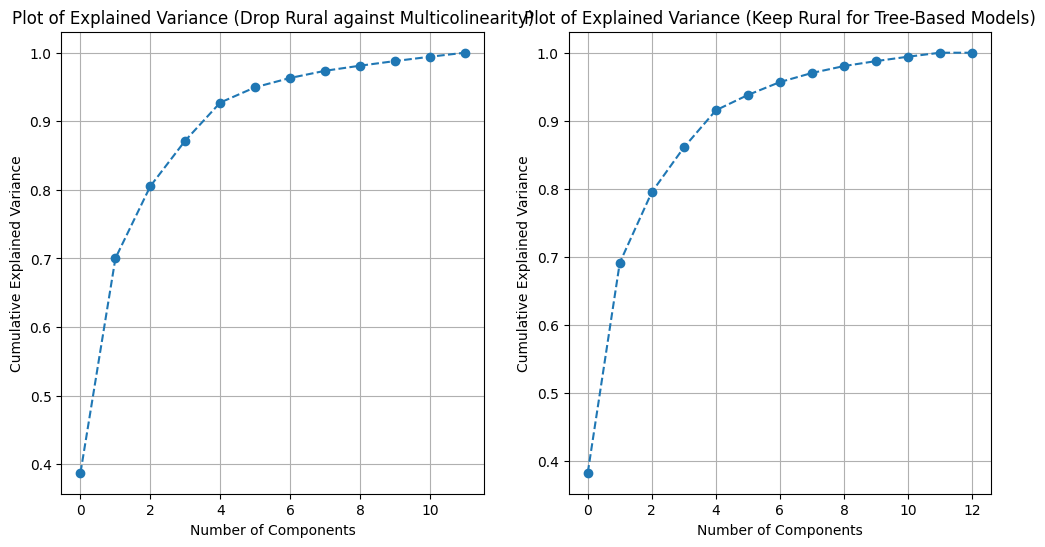

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
# Initialize PCA to keep all components
pca_full = PCA()

X_pca = df_train_scaled.drop(['cat_onehot__property_area_Rural'], axis=1)

# Fit PCA to the data
pca_full.fit(X_pca)

# Plot the cumulative explained variance
ax1.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
ax1.set_title("Plot of Explained Variance (Drop Rural against Multicolinearity)")
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative Explained Variance')
ax1.grid(True)

# Initialize PCA to keep all components
pca_full = PCA()

X_pca_tree = df_train_scaled.copy()


# Fit PCA to the data
pca_full.fit(X_pca_tree)

# Plot the cumulative explained variance
ax2.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
ax2.set_title("Plot of Explained Variance (Keep Rural for Tree-Based Models)")
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.grid(True)

# Machine Learning Setup

## Global Configuration Values


In [ ]:
# Dictionary of Results
model_comparisons = {}

scoring_functions = ['f1', 'f1_weighted', 'roc_auc']
pca_components = [4, 7, 10]

## Helper Functions

In [ ]:
def train_model(model, X_train_scaled, y_train,
                X_test_scaled, y_test,
                param_grid, ispca, n_components, scoring, cv=5,
                              numeric_features=  ['applicant_income',
                                          'coapplicant_income',
                                          'loan_amount' ]):

  if(ispca):
    print ('Components:', i)
    pca = PCA(n_components=n_components,
                         random_state=42)
    X_train_scaled = pca.fit_transform(X_train_scaled)
    X_test_scaled = pca.transform(X_test_scaled)

  # Set up the GridSearchCV
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                            scoring=scoring, n_jobs=-1, verbose=1)

  # Fit the grid search model
  grid_search.fit(X_train_scaled, y_train)

  # Best parameters found by Grid Search
  print("Best Hyperparameters:", grid_search.best_params_)

  return (grid_search.best_estimator_,
          X_train_scaled,
          X_test_scaled,
          y_train,
          y_test,
          grid_search.best_params_,
          )

In [ ]:
def evaluate_model (model, X_train, y_train, X_test, y_test, best_params,
                    preprocessor, run_label):
  print(f'-----{run_label}-----')

  train_pred = model.predict(X_train)
  y_pred = model.predict(X_test)

  # evaluate train
  train_accuracy = round(accuracy_score(y_train, train_pred)*100, 2)
  train_conf_matrix = confusion_matrix(y_train, train_pred)
  train_class_report = classification_report(y_train, train_pred)
  train_roc_auc = round(roc_auc_score(y_train, train_pred)*100, 2)
  train_f1 = round(f1_score(y_train, train_pred)*100, 2)
  train_f1_weighted = round(f1_score(y_train, train_pred, average='weighted')*100, 2)

  # evaluate test
  accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
  conf_matrix = confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred)
  roc_auc = round(roc_auc_score(y_test, y_pred)*100, 2)
  f1 = round(f1_score(y_test, y_pred)*100, 2)
  f1_weighted = round(f1_score(y_test, y_pred, average='weighted')*100, 2)

  # Printing evaluation metrics
  print("Training Confusion Matrix:\n", train_conf_matrix)
  print("Testing Confusion Matrix:\n", conf_matrix)
  print("Accuracy: Test", accuracy, ' - ' , train_accuracy, 'Train')
  print("ROC AUC: Test", roc_auc, ' - ' , train_roc_auc, 'Train')
  print("F1-score:", f1, ' - ' , train_f1, 'Train')
  print("Weighted F1-score:", f1_weighted, ' - ' , train_f1_weighted, 'Train')

  print("Training Classification Report:\n", train_class_report)
  print("Test Classification Report:\n", class_report)

  #Save the run stats
  model_comparisons[run_label] = {'accuracy': accuracy,
                                  'conf_matrix': conf_matrix,
                                  'class_report': class_report,
                                  'roc_auc' : roc_auc,
                                  'f1' : f1,
                                  'f1_weighted': f1_weighted,
                                  'best_params': best_params,
                                  'model': model}


In [ ]:
def model_summaries (model_list):
  df_models = pd.DataFrame.from_dict(model_comparisons, orient='index')
  df_models = df_models[['f1_weighted', 'roc_auc', 'f1', 'accuracy' ]]
  df_models = df_models.reset_index()
  df_models.rename(columns={'index': 'model'}, inplace=True)

  df_models_transposed = df_models.T
  df_models_transposed.columns = df_models_transposed.loc['model']
  df_models_transposed = df_models_transposed[model_list]
  return df_models_transposed[1:]

In [ ]:
def print_evaluations (key_list):
  for key in key_list:
    print(key)
    print (model_comparisons[key]['conf_matrix'])
    print ('Accuracy:', model_comparisons[key]['accuracy'])
    print ('ROC-AUC', model_comparisons[key]['roc_auc'])
    print ('F1-score', model_comparisons[key]['f1'])
    print ('Weighted F1-score', model_comparisons[key]['f1_weighted'])
    print (model_comparisons[key]['class_report'])
    print()


## Param Grid Setup

In [ ]:
def get_logreg_grid ():
  param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
  }
  return param_grid

In [ ]:
def get_svm_grid ():
  '''
  tested the following grid but it takes a long time
  and the resulting best hyperparameters are still the same

    param_grid =  {
    'kernel': ['linear', 'rbf', 'poly'], #['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10], #[0.1, 1, 10, 100, 1000],
    'degree': [2, 3],   #[2, 3, 4, 5],
    'gamma': ['scale', 'auto'],#['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
	  'class_weight': ['balanced', None],
    }

  reducing the parameter grid further for quicker runs in the future
  '''

  param_grid =  {
    'kernel': ['linear', 'rbf'], #['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10], #[0.1, 1, 10, 100, 1000],
    #'degree': [2, 3],   #[2, 3, 4, 5],
    'gamma': ['scale', 'auto'],#['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
	  'class_weight': ['balanced', None],
  }
  return param_grid

In [ ]:
def get_decisiontree_grid (strict=False):
  param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [20, 30, 50],
    'min_samples_leaf': [10, 20, 30],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
  }
  if (strict):
    param_grid['min_samples_split'] = [2, 5, 10]
    param_grid['min_samples_leaf'] = [1, 2, 4]

  return param_grid

In [ ]:
def get_forest_grid (strict=False):
  #param_grid = get_decisiontree_grid(strict)
  #param_grid['n_estimators'] = [100]
  param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
  }
  if (strict):
    param_grid['min_samples_split'] = [2, 5, 10]
    param_grid['min_samples_leaf'] = [1, 2, 4]

  return param_grid

# Logistic Regression

## Vanilla Logistic Regression

- Plain Logistic Regression performs the same whether optimizing for F1-score, F1-weighted, or ROC_AUC
- The training metrics are all lower than the test metrics. I've checked the following:
  - Train-test split done before any imputation
  - Stratified sampling was done, the proportion of class1 and class0 items on train and test are very similar.
  - Test data was cleaned and imputed using the same preprocessor that was used for training data.

Perhaps the reason for train being lower than test is the small number of samples on test, and the huge class imbalance (the models suck at predicting class 0 because there are so few class 0 data points).

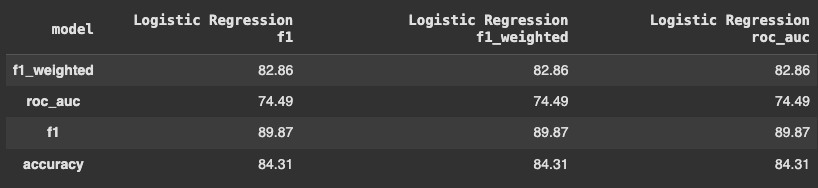

In [ ]:
# Best Hyperparameters:
# {'C': 1}

for scoring in scoring_functions:
  my_X_train = df_train_scaled.drop(['cat_onehot__property_area_Rural'], axis=1)
  my_X_test = df_test_scaled.drop(['cat_onehot__property_area_Rural'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  model = LogisticRegression(max_iter=10000, random_state=42,)
  #1000 fails to converge

  param_grid = get_logreg_grid()
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                f'Logistic Regression {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'C': 1}
-----Logistic Regression f1-----
Training Confusion Matrix:
 [[ 42  75]
 [  6 285]]
Testing Confusion Matrix:
 [[15 14]
 [ 2 71]]
Accuracy: Test 84.31  -  80.15 Train
ROC AUC: Test 74.49  -  66.92 Train
F1-score: 89.87  -  87.56 Train
Weighted F1-score: 82.86  -  77.05 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.36      0.51       117
         1.0       0.79      0.98      0.88       291

    accuracy                           0.80       408
   macro avg       0.83      0.67      0.69       408
weighted avg       0.82      0.80      0.77       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.52      0.65        29
         1.0       0.84      0.97      0.90        73

    accuracy                           0.84       102
   macro avg       0.86   

In [ ]:
print('training spread:\n', y_train.value_counts(normalize=True))
print('test spread:\n', y_test.value_counts(normalize=True))

training spread:
 loan_status
1.0    0.713235
0.0    0.286765
Name: proportion, dtype: float64
test spread:
 loan_status
1.0    0.715686
0.0    0.284314
Name: proportion, dtype: float64


In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                   'Logistic Regression f1_weighted',
                   'Logistic Regression roc_auc'])

df_summary

model       Logistic Regression f1 Logistic Regression f1_weighted  \
f1_weighted                  82.86                           82.86   
roc_auc                      74.49                           74.49   
f1                           89.87                           89.87   
accuracy                     84.31                           84.31   

model       Logistic Regression roc_auc  
f1_weighted                       82.86  
roc_auc                           74.49  
f1                                89.87  
accuracy                          84.31

### Coefficients

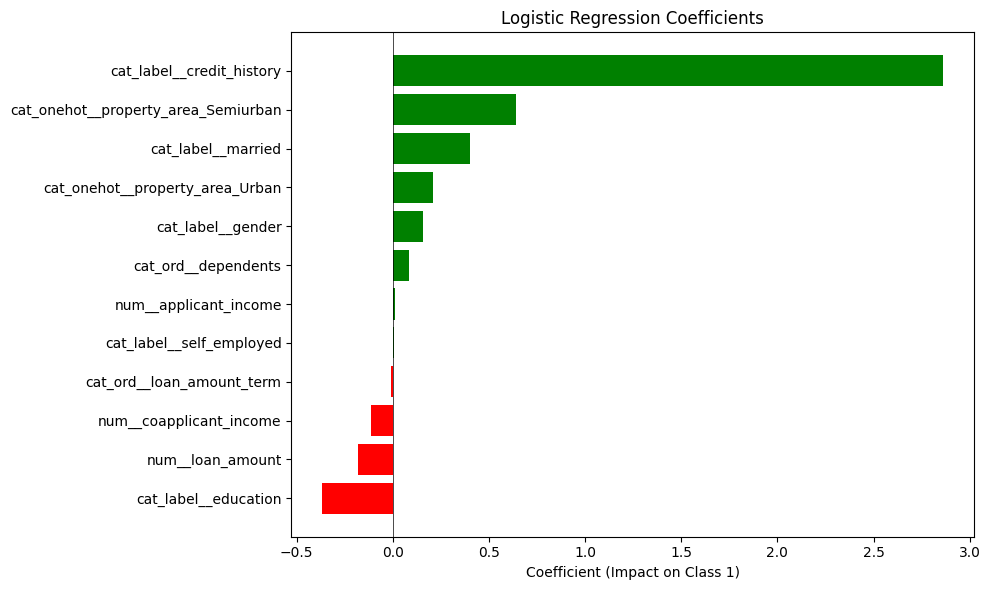

In [ ]:
my_model = model_comparisons['Logistic Regression f1']['model']
coefficients = my_model.coef_[0]
features = my_X_train.columns  # or use your saved feature names
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient')

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'],
         color=np.where(coef_df['Coefficient'] > 0, 'green', 'red'))
plt.title('Logistic Regression Coefficients')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('Coefficient (Impact on Class 1)')
plt.tight_layout()
plt.show()

## Logistic Regression Minus Dependents

Models trained by dropping the `dependents` column - which was identified to be significantly related with `gender` and `married` - perform the same way as having all of the features.


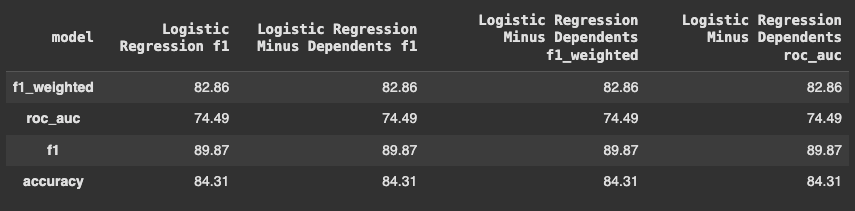

In [ ]:
# Best Hyperparameters:
# {'C': 1}



for scoring in scoring_functions:
  my_X_train = df_train_scaled.drop(['cat_onehot__property_area_Rural',
                                     'cat_ord__dependents'], axis=1)
  my_X_test = df_test_scaled.drop(['cat_onehot__property_area_Rural',
                                   'cat_ord__dependents'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  model = LogisticRegression(max_iter=10000, random_state=42,)
  #1000 fails to converge

  param_grid = get_logreg_grid()
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                f'Logistic Regression Minus Dependents {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'C': 1}
-----Logistic Regression Minus Dependents f1-----
Training Confusion Matrix:
 [[ 41  76]
 [  6 285]]
Testing Confusion Matrix:
 [[15 14]
 [ 2 71]]
Accuracy: Test 84.31  -  79.9 Train
ROC AUC: Test 74.49  -  66.49 Train
F1-score: 89.87  -  87.42 Train
Weighted F1-score: 82.86  -  76.69 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.35      0.50       117
         1.0       0.79      0.98      0.87       291

    accuracy                           0.80       408
   macro avg       0.83      0.66      0.69       408
weighted avg       0.81      0.80      0.77       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.52      0.65        29
         1.0       0.84      0.97      0.90        73

    accuracy                           0.84       102
   macro a

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                   'Logistic Regression Minus Dependents f1',
                   'Logistic Regression Minus Dependents f1_weighted',
                   'Logistic Regression Minus Dependents roc_auc'])

df_summary

model       Logistic Regression f1 Logistic Regression Minus Dependents f1  \
f1_weighted                  82.86                                   82.86   
roc_auc                      74.49                                   74.49   
f1                           89.87                                   89.87   
accuracy                     84.31                                   84.31   

model       Logistic Regression Minus Dependents f1_weighted  \
f1_weighted                                            82.86   
roc_auc                                                74.49   
f1                                                     89.87   
accuracy                                               84.31   

model       Logistic Regression Minus Dependents roc_auc  
f1_weighted                                        82.86  
roc_auc                                            74.49  
f1                                                 89.87  
accuracy                                           84.31

## Logistic Regression PCA

- All PCA Variants had a lot lower performance metrics than without using PCA. (10, 7, 7)
- every PCA Model simply guesses 1 on all rows if we don't use balanced class weights
- Better just stick to Linear Regression without PCA
- Interestingly, training scores are higher than test scores when applying PCA

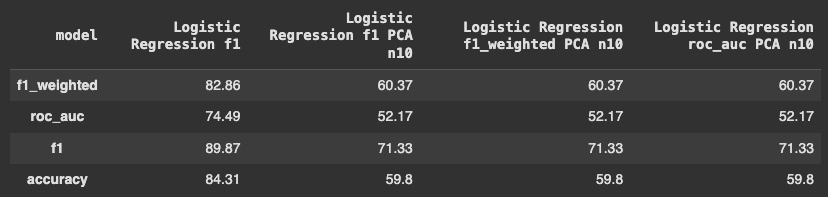

In [ ]:
for scoring in scoring_functions:
  for i in pca_components:
    my_X_train = df_train_scaled.drop(['cat_onehot__property_area_Rural'], axis=1)
    my_X_test = df_test_scaled.drop(['cat_onehot__property_area_Rural'], axis=1)
    my_y_train = y_train
    my_y_test = y_test

    param_grid = get_logreg_grid()
    #without the balanced class weights, PCA models just predict 1 always
    param_grid['class_weight'] = ['balanced']
    model = LogisticRegression(max_iter=10000, random_state=42,)
    ispca = True
    n_components = i


    best_model, my_X_train, my_X_test, \
    my_y_train, my_y_test, best_params,  = train_model(model,
                                            my_X_train, my_y_train,
                                            my_X_test, my_y_test,
                                            param_grid, ispca,
                                            n_components, scoring)

    evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                  best_params, preprocessor,
                   f'Logistic Regression {scoring} PCA n{i}')
    # PCA models performed much more poorly

  #true negatives 0,0     false positives 0, 1
  #false negatives 1,0    true positives 1,1

Components: 4
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'C': 0.01, 'class_weight': 'balanced'}
-----Logistic Regression f1 PCA n4-----
Training Confusion Matrix:
 [[ 54  63]
 [118 173]]
Testing Confusion Matrix:
 [[10 19]
 [37 36]]
Accuracy: Test 45.1  -  55.64 Train
ROC AUC: Test 41.9  -  52.8 Train
F1-score: 56.25  -  65.65 Train
Weighted F1-score: 47.74  -  57.54 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.31      0.46      0.37       117
         1.0       0.73      0.59      0.66       291

    accuracy                           0.56       408
   macro avg       0.52      0.53      0.52       408
weighted avg       0.61      0.56      0.58       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.21      0.34      0.26        29
         1.0       0.65      0.49      0.56        73

    accuracy                   

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                   'Logistic Regression f1 PCA n10',
                   'Logistic Regression f1_weighted PCA n7',
                   'Logistic Regression roc_auc PCA n7'])

df_summary

model       Logistic Regression f1 Logistic Regression f1 PCA n10  \
f1_weighted                  82.86                          55.24   
roc_auc                      74.49                          53.61   
f1                           89.87                          61.29   
accuracy                     84.31                          52.94   

model       Logistic Regression f1_weighted PCA n7  \
f1_weighted                                  57.07   
roc_auc                                      53.94   
f1                                           64.06   
accuracy                                      54.9   

model       Logistic Regression roc_auc PCA n7  
f1_weighted                              58.94  
roc_auc                                  56.35  
f1                                       65.62  
accuracy                                 56.86

# SVM

## Vanilla SVM

SVM using f1/f1-weighted scoring performs slightly worse than Logistic Regression across the board. Using. roc_auc drops the performance even more.

Grid Search picks `class_weights = None` which makes the model tuned using roc_auc scoring to just predict all class 1's.

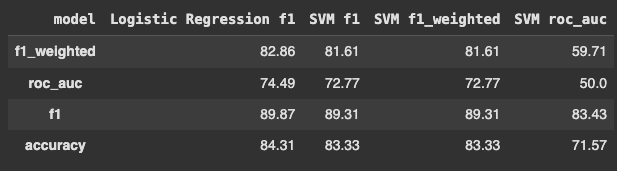

In [ ]:
for scoring in scoring_functions:
  model = SVC(random_state=42)
  param_grid = get_svm_grid()
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['cat_onehot__property_area_Rural'], axis=1)
  my_X_test = df_test_scaled.drop(['cat_onehot__property_area_Rural'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                f'SVM {scoring}')


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
-----SVM f1-----
Training Confusion Matrix:
 [[ 40  77]
 [  5 286]]
Testing Confusion Matrix:
 [[14 15]
 [ 2 71]]
Accuracy: Test 83.33  -  79.9 Train
ROC AUC: Test 72.77  -  66.23 Train
F1-score: 89.31  -  87.46 Train
Weighted F1-score: 81.61  -  76.54 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.34      0.49       117
         1.0       0.79      0.98      0.87       291

    accuracy                           0.80       408
   macro avg       0.84      0.66      0.68       408
weighted avg       0.82      0.80      0.77       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.48      0.62        29
         1.0       0.83      0.97      0.89        73

    accuracy                     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                   'SVM f1',
                   'SVM f1_weighted',
                   'SVM roc_auc'])

df_summary

model       Logistic Regression f1 SVM f1 SVM f1_weighted SVM roc_auc
f1_weighted                  82.86  81.61           81.61       59.71
roc_auc                      74.49  72.77           72.77        50.0
f1                           89.87  89.31           89.31       83.43
accuracy                     84.31  83.33           83.33       71.57

## SVM Manual Minus Dependents

Dropping the `dependents` column which was identified to be significantly related with `gender` and `married` seems to not negatively affect the model's performance.

Scoring with roc_auc produces a model that seems more inclined to predict class 0, leading to more true and false negatives compared to the other two scoring models.


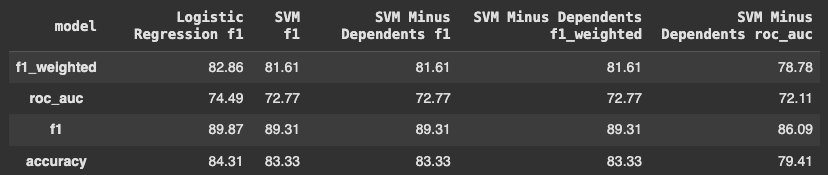

In [ ]:
for scoring in scoring_functions:
  model = SVC(random_state=42)
  param_grid = get_svm_grid()
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['cat_onehot__property_area_Rural',
                                     'cat_ord__dependents'], axis=1)
  my_X_test = df_test_scaled.drop(['cat_onehot__property_area_Rural',
                                   'cat_ord__dependents'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                f'SVM Minus Dependents {scoring}')


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
-----SVM Minus Dependents f1-----
Training Confusion Matrix:
 [[ 40  77]
 [  5 286]]
Testing Confusion Matrix:
 [[14 15]
 [ 2 71]]
Accuracy: Test 83.33  -  79.9 Train
ROC AUC: Test 72.77  -  66.23 Train
F1-score: 89.31  -  87.46 Train
Weighted F1-score: 81.61  -  76.54 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.34      0.49       117
         1.0       0.79      0.98      0.87       291

    accuracy                           0.80       408
   macro avg       0.84      0.66      0.68       408
weighted avg       0.82      0.80      0.77       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.48      0.62        29
         1.0       0.83      0.97      0.89        73

    accuracy    

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                   'SVM f1',
                   'SVM Minus Dependents f1',
                   'SVM Minus Dependents f1_weighted',
                   'SVM Minus Dependents roc_auc'])

df_summary

model       Logistic Regression f1 SVM f1 SVM Minus Dependents f1  \
f1_weighted                  82.86  81.61                   81.61   
roc_auc                      74.49  72.77                   72.77   
f1                           89.87  89.31                   89.31   
accuracy                     84.31  83.33                   83.33   

model       SVM Minus Dependents f1_weighted SVM Minus Dependents roc_auc  
f1_weighted                            81.61                        78.78  
roc_auc                                72.77                        72.11  
f1                                     89.31                        86.09  
accuracy                               83.33                        79.41

## SVM PCA

- Each variant performed best with `n_components = 10`. They all performed worse than vanilla SVM.
- similar to Logistic Regression PCA, balanced class weights are required with PCA to prevent the models from predicting all 1's


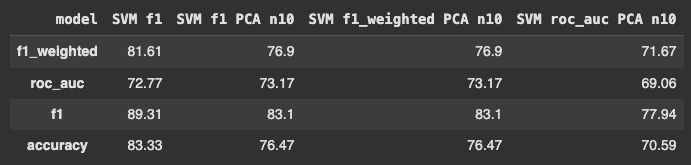

In [ ]:
for scoring in scoring_functions:
  for i in pca_components:

    model = SVC(random_state=42)
    param_grid = get_svm_grid()
    #without the balanced class weights, PCA models just predict 1 always
    #for 2 out of the 3 variants
    param_grid['class_weight'] = ['balanced']

    ispca = True
    n_components = i

    my_X_train = df_train_scaled.drop(['cat_onehot__property_area_Rural',
                                     'cat_ord__dependents'], axis=1)
    my_X_test = df_test_scaled.drop(['cat_onehot__property_area_Rural',
                                    'cat_ord__dependents'], axis=1)
    my_y_train = y_train
    my_y_test = y_test

    best_model, my_X_train, my_X_test, \
    my_y_train, my_y_test, best_params,  = train_model(model,
                                            my_X_train, my_y_train,
                                            my_X_test, my_y_test,
                                            param_grid, ispca,
                                            n_components, scoring)

    evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                  best_params, preprocessor,
                    f'SVM {scoring} PCA n{i}')

  #true negatives 0,0     false positives 0, 1
  #false negatives 1,0    true positives 1,1

Components: 4
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
-----SVM f1 PCA n4-----
Training Confusion Matrix:
 [[ 47  70]
 [ 45 246]]
Testing Confusion Matrix:
 [[ 3 26]
 [22 51]]
Accuracy: Test 52.94  -  71.81 Train
ROC AUC: Test 40.1  -  62.35 Train
F1-score: 68.0  -  81.05 Train
Weighted F1-score: 51.83  -  70.71 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.40      0.45       117
         1.0       0.78      0.85      0.81       291

    accuracy                           0.72       408
   macro avg       0.64      0.62      0.63       408
weighted avg       0.70      0.72      0.71       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.12      0.10      0.11        29
         1.0       0.66      0.70      0.68        73

    accuracy 

In [ ]:
df_summary = model_summaries(['SVM f1', 'SVM f1 PCA n10',
                              'SVM f1_weighted PCA n10',
                              'SVM roc_auc PCA n10'])

df_summary

model       SVM f1 SVM f1 PCA n10 SVM f1_weighted PCA n10 SVM roc_auc PCA n10
f1_weighted  81.61           76.9                    76.9               71.67
roc_auc      72.77          73.17                   73.17               69.06
f1           89.31           83.1                    83.1               77.94
accuracy     83.33          76.47                   76.47               70.59

# Decision Tree


## Vanilla Decision Tree - Big Samples

By using `min_samples_split` and `min_samples_leaf` on the larger end (10 - 50) I am hoping to get a model that is able to generalize its classifications.


Decision Trees using f1 and f1-weighted scoring performed the best, with roc_auc scoring having markedly worse performance.

The f1 tree focused on the `credit_history` parameter - which was expected based on the correlations we saw - as well as the `loan_amount` and `coapplicant_income` parameters.



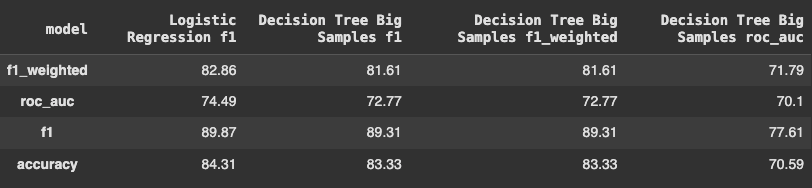

In [ ]:
for scoring in scoring_functions:

  model = DecisionTreeClassifier(random_state=42)
  param_grid = get_decisiontree_grid()
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.copy()
  my_X_test = df_test_scaled.copy()
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                 f'Decision Tree Big Samples {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 30, 'min_samples_split': 20}
-----Decision Tree Big Samples f1-----
Training Confusion Matrix:
 [[ 40  77]
 [  5 286]]
Testing Confusion Matrix:
 [[14 15]
 [ 2 71]]
Accuracy: Test 83.33  -  79.9 Train
ROC AUC: Test 72.77  -  66.23 Train
F1-score: 89.31  -  87.46 Train
Weighted F1-score: 81.61  -  76.54 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.34      0.49       117
         1.0       0.79      0.98      0.87       291

    accuracy                           0.80       408
   macro avg       0.84      0.66      0.68       408
weighted avg       0.82      0.80      0.77       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.48      0.62        29
    

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                              'Decision Tree Big Samples f1',
                              'Decision Tree Big Samples f1_weighted',
                              'Decision Tree Big Samples roc_auc'])

df_summary

model       Logistic Regression f1 Decision Tree Big Samples f1  \
f1_weighted                  82.86                        81.61   
roc_auc                      74.49                        72.77   
f1                           89.87                        89.31   
accuracy                     84.31                        83.33   

model       Decision Tree Big Samples f1_weighted  \
f1_weighted                                 81.61   
roc_auc                                     72.77   
f1                                          89.31   
accuracy                                    83.33   

model       Decision Tree Big Samples roc_auc  
f1_weighted                             71.79  
roc_auc                                  70.1  
f1                                      77.61  
accuracy                                70.59

[0.         0.03243119 0.05730198 0.         0.         0.
 0.         0.91026682 0.         0.         0.         0.
 0.        ]


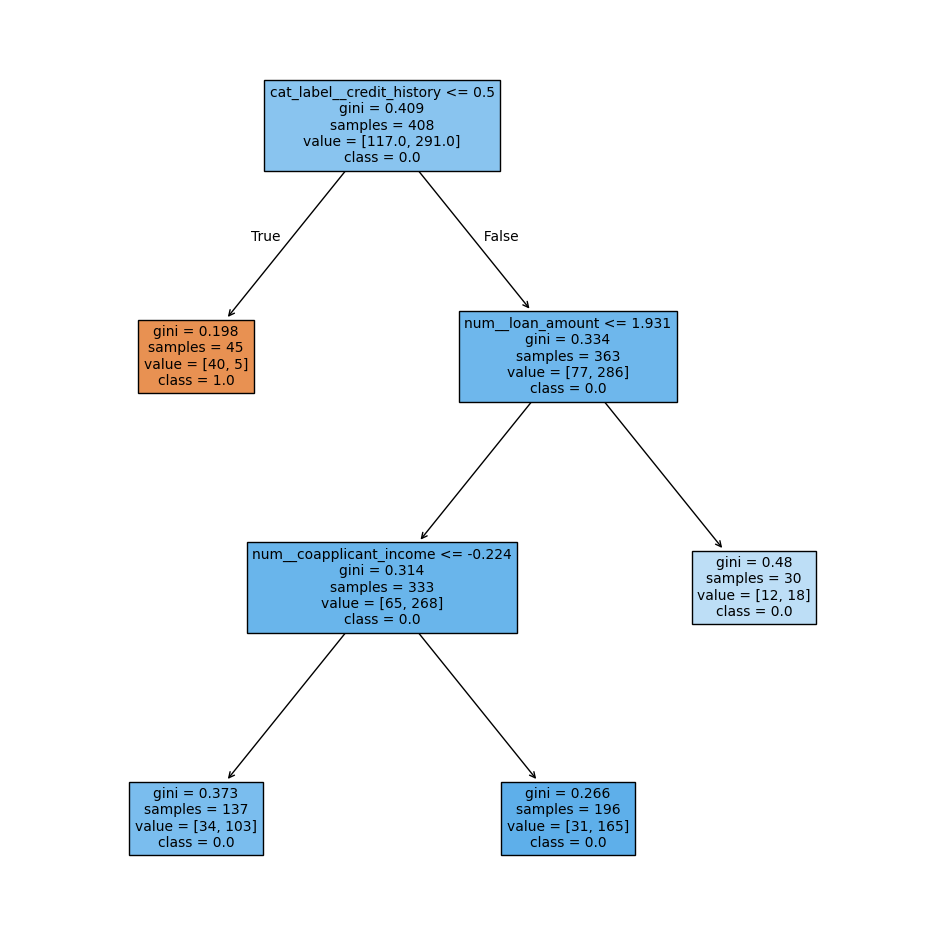

In [ ]:
# Visualize the best-performing decision tree
plt.figure(figsize=(12, 12))
decision_tree = model_comparisons["Decision Tree Big Samples f1"]["model"]
print (decision_tree.feature_importances_)
tree.plot_tree(decision_tree, feature_names=my_X_train.columns,
               class_names=[str(el) for el in my_y_train.unique()],
               filled=True, fontsize=10)
plt.show()

## Vanilla Decision Tree - Small Samples

Here I test `min_samples_split` and `min_samples_leaf` on the smaller end (1 - 10) to see if perhaps the models can perform better, at the risk of just memorizing / overfitting the training data.

Optimizing for f1-score/weighted f1-score performed the best, but all models did worse than when using bigger `min_sampless`, which may actually reflect overfitting.

The f1 tree still focused on the `credit_history` as the first predictor, and then used `applicant_income`, and `loan_amount`, and `coapplicant_income` to do further splits, resulting in more splits at level 2 and 3


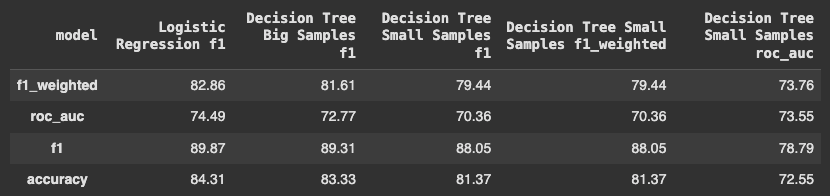

In [ ]:
for scoring in scoring_functions:
  model = DecisionTreeClassifier(random_state=42)
  param_grid = get_decisiontree_grid(True)
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.copy()
  my_X_test = df_test_scaled.copy()
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                f'Decision Tree Small Samples {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
-----Decision Tree Small Samples f1-----
Training Confusion Matrix:
 [[ 43  74]
 [  4 287]]
Testing Confusion Matrix:
 [[13 16]
 [ 3 70]]
Accuracy: Test 81.37  -  80.88 Train
ROC AUC: Test 70.36  -  67.69 Train
F1-score: 88.05  -  88.04 Train
Weighted F1-score: 79.44  -  77.83 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.37      0.52       117
         1.0       0.80      0.99      0.88       291

    accuracy                           0.81       408
   macro avg       0.85      0.68      0.70       408
weighted avg       0.83      0.81      0.78       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.45      0.58        29
  

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                              'Decision Tree Big Samples f1',
                              'Decision Tree Small Samples f1',
                              'Decision Tree Small Samples f1_weighted',
                              'Decision Tree Small Samples roc_auc'])

df_summary

model       Logistic Regression f1 Decision Tree Big Samples f1  \
f1_weighted                  82.86                        81.61   
roc_auc                      74.49                        72.77   
f1                           89.87                        89.31   
accuracy                     84.31                        83.33   

model       Decision Tree Small Samples f1  \
f1_weighted                          79.44   
roc_auc                              70.36   
f1                                   88.05   
accuracy                             81.37   

model       Decision Tree Small Samples f1_weighted  \
f1_weighted                                   79.44   
roc_auc                                       70.36   
f1                                            88.05   
accuracy                                      81.37   

model       Decision Tree Small Samples roc_auc  
f1_weighted                               73.76  
roc_auc                                   73.55  
f1                                        78.79  
accuracy                                  72.55

[0.12102468 0.00693708 0.09144328 0.         0.         0.
 0.         0.78059497 0.         0.         0.         0.
 0.        ]


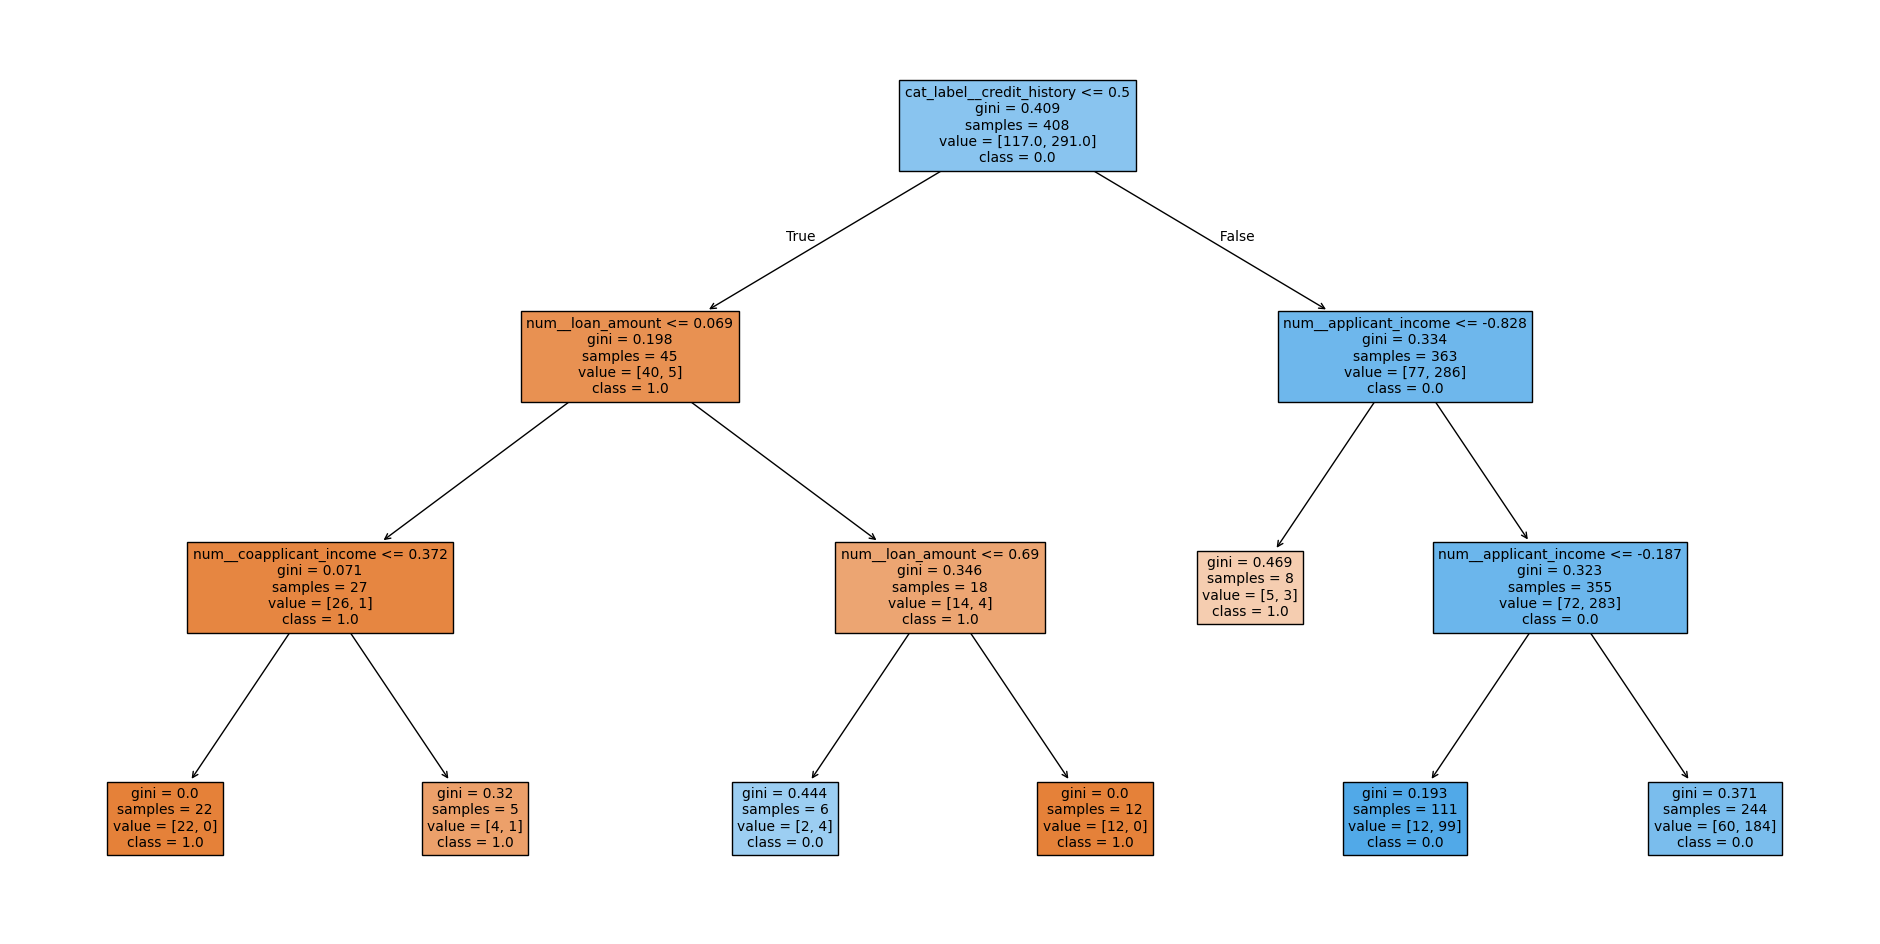

In [ ]:
# Visualize the best-performing decision tree
plt.figure(figsize=(24, 12))
decision_tree = model_comparisons["Decision Tree Small Samples f1"]["model"]
print (decision_tree.feature_importances_)
tree.plot_tree(decision_tree, feature_names=my_X_train.columns,
               class_names=[str(el) for el in my_y_train.unique()],
               filled=True, fontsize=10)
plt.show()

## Decision Tree Minus Dependents - Big Samples

Tested to see what would happen if we dropped the `dependents` column that was already highly correlated to `married` and `gender`.

The f1/f1_weigghted models had the same performance metrics across the board, and were equivalent to the model that kept the `dependents` parameter. The roc_auc model performed worse.

The f1 decision tree minus dependents is also identical to the f1 decision tree with dependents, which makes sense because the parameter was not used to make any splits.

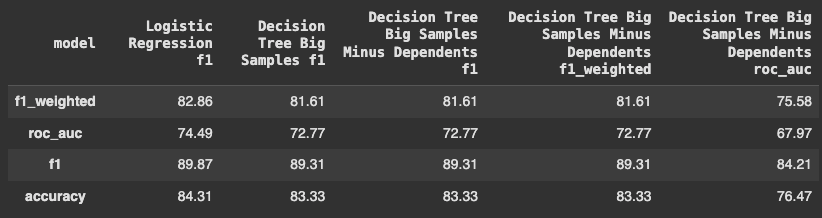

In [ ]:
for scoring in scoring_functions:
  model = DecisionTreeClassifier(random_state=42)
  param_grid = get_decisiontree_grid()
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['cat_ord__dependents'], axis=1)
  my_X_test = df_test_scaled.drop(['cat_ord__dependents'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                 f'Decision Tree Big Samples Minus Dependents {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 30, 'min_samples_split': 20}
-----Decision Tree Big Samples Minus Dependents f1-----
Training Confusion Matrix:
 [[ 40  77]
 [  5 286]]
Testing Confusion Matrix:
 [[14 15]
 [ 2 71]]
Accuracy: Test 83.33  -  79.9 Train
ROC AUC: Test 72.77  -  66.23 Train
F1-score: 89.31  -  87.46 Train
Weighted F1-score: 81.61  -  76.54 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.34      0.49       117
         1.0       0.79      0.98      0.87       291

    accuracy                           0.80       408
   macro avg       0.84      0.66      0.68       408
weighted avg       0.82      0.80      0.77       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.48      0.

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                              'Decision Tree Big Samples f1',
                              'Decision Tree Big Samples Minus Dependents f1',
                              'Decision Tree Big Samples Minus Dependents f1_weighted',
                              'Decision Tree Big Samples Minus Dependents roc_auc'])

df_summary

model       Logistic Regression f1 Decision Tree Big Samples f1  \
f1_weighted                  82.86                        81.61   
roc_auc                      74.49                        72.77   
f1                           89.87                        89.31   
accuracy                     84.31                        83.33   

model       Decision Tree Big Samples Minus Dependents f1  \
f1_weighted                                         81.61   
roc_auc                                             72.77   
f1                                                  89.31   
accuracy                                            83.33   

model       Decision Tree Big Samples Minus Dependents f1_weighted  \
f1_weighted                                              81.61       
roc_auc                                                  72.77       
f1                                                       89.31       
accuracy                                                 83.33       

model       Decision Tree Big Samples Minus Dependents roc_auc  
f1_weighted                                              75.58  
roc_auc                                                  67.97  
f1                                                       84.21  
accuracy                                                 76.47

[0.         0.03243119 0.05730198 0.         0.         0.
 0.         0.91026682 0.         0.         0.         0.        ]


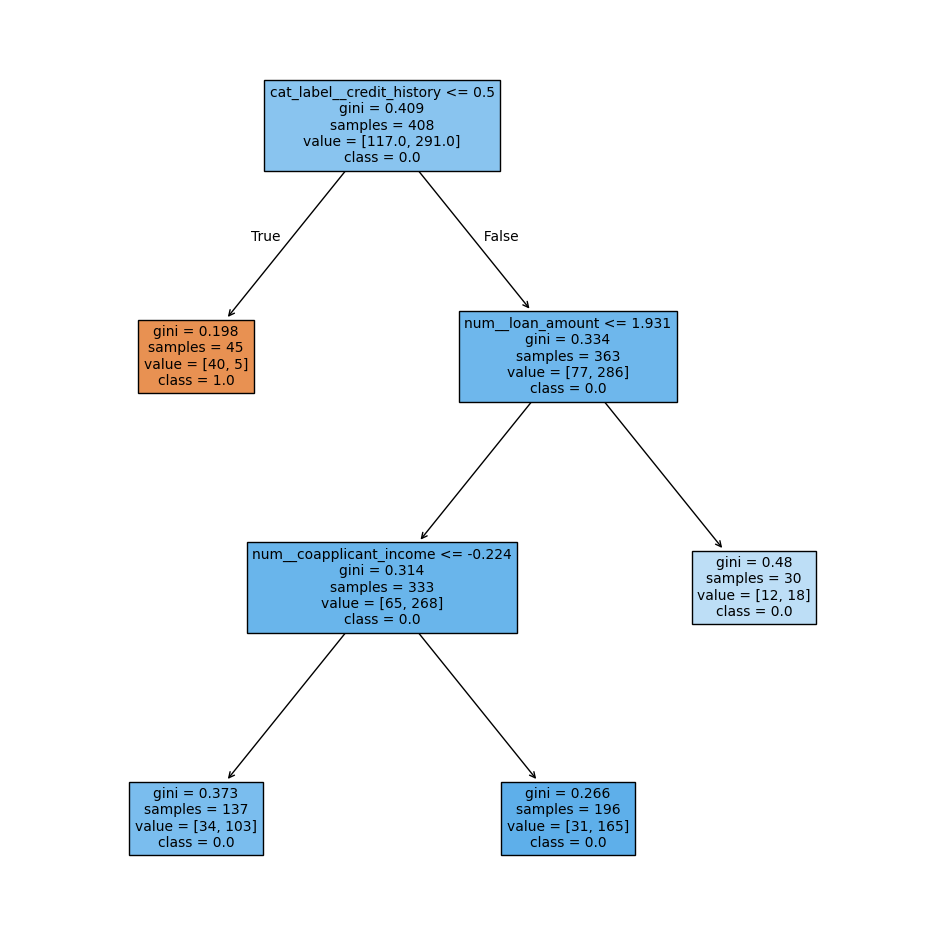

In [ ]:
# Visualize the best-performing decision tree
plt.figure(figsize=(12, 12))
decision_tree = model_comparisons["Decision Tree Big Samples Minus Dependents f1"]["model"]
print (decision_tree.feature_importances_)
tree.plot_tree(decision_tree, feature_names=my_X_train.columns,
               class_names=[str(el) for el in my_y_train.unique()],
               filled=True, fontsize=10)
plt.show()

## Decision Tree Minus Dependents - Small Samples

Tested to see what would happen if we dropped the `dependents` column that was already highly correlated to `married` and `gender`.

Optimizing for f1/f1_weighted outperformed Vanilla Small Samples slightly across the board by around to \~1% to 3.5%. Compared with Vanilla Big Samples, they had a slightly higher f1_weighted score and a slightly higher roc_auc.

The plot of this tree is the most complex so far.




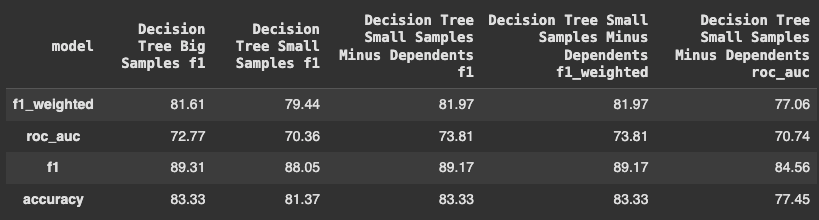

In [ ]:
for scoring in scoring_functions:
  model = DecisionTreeClassifier(random_state=42)
  param_grid = get_decisiontree_grid(True)
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['cat_ord__dependents'], axis=1)
  my_X_test = df_test_scaled.drop(['cat_ord__dependents'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                f'Decision Tree Small Samples Minus Dependents {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Hyperparameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
-----Decision Tree Small Samples Minus Dependents f1-----
Training Confusion Matrix:
 [[ 48  69]
 [  5 286]]
Testing Confusion Matrix:
 [[15 14]
 [ 3 70]]
Accuracy: Test 83.33  -  81.86 Train
ROC AUC: Test 73.81  -  69.65 Train
F1-score: 89.17  -  88.54 Train
Weighted F1-score: 81.97  -  79.35 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.41      0.56       117
         1.0       0.81      0.98      0.89       291

    accuracy                           0.82       408
   macro avg       0.86      0.70      0.73       408
weighted avg       0.83      0.82      0.79       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.52 

In [ ]:
df_summary = model_summaries(['Decision Tree Big Samples f1',
                              'Decision Tree Small Samples f1',
                              'Decision Tree Small Samples Minus Dependents f1',
                              'Decision Tree Small Samples Minus Dependents f1_weighted',
                              'Decision Tree Small Samples Minus Dependents roc_auc'])

df_summary

model       Decision Tree Big Samples f1 Decision Tree Small Samples f1  \
f1_weighted                        81.61                          79.44   
roc_auc                            72.77                          70.36   
f1                                 89.31                          88.05   
accuracy                           83.33                          81.37   

model       Decision Tree Small Samples Minus Dependents f1  \
f1_weighted                                           81.97   
roc_auc                                               73.81   
f1                                                    89.17   
accuracy                                              83.33   

model       Decision Tree Small Samples Minus Dependents f1_weighted  \
f1_weighted                                              81.97         
roc_auc                                                  73.81         
f1                                                       89.17         
accuracy                                                 83.33         

model       Decision Tree Small Samples Minus Dependents roc_auc  
f1_weighted                                              77.06    
roc_auc                                                  70.74    
f1                                                       84.56    
accuracy                                                 77.45

[0.08082023 0.08233851 0.13098428 0.00256647 0.02167653 0.00123715
 0.         0.61367637 0.01175101 0.04812954 0.         0.00681991]


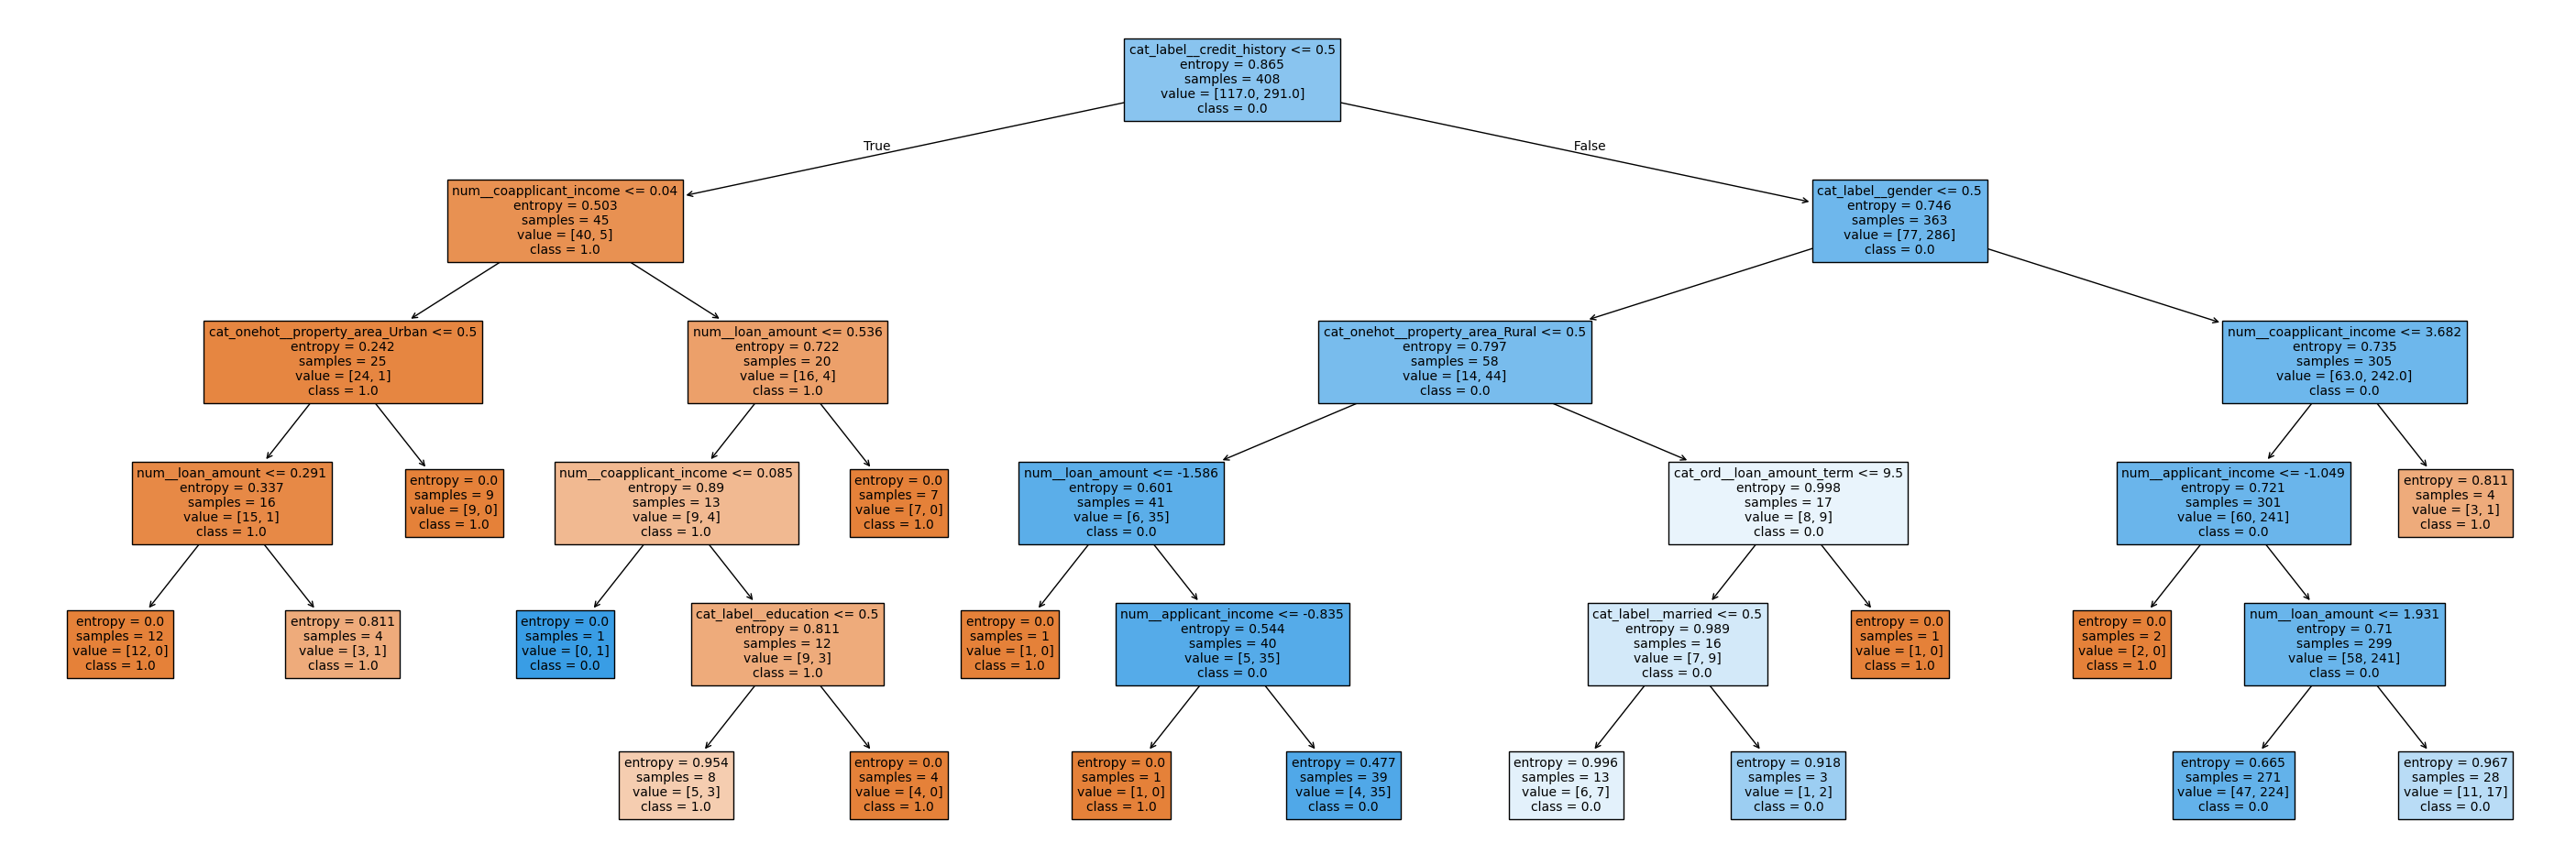

In [ ]:
# Visualize the best-performing decision tree
plt.figure(figsize=(36, 12))
decision_tree = model_comparisons["Decision Tree Small Samples Minus Dependents f1_weighted"]["model"]
print (decision_tree.feature_importances_)
tree.plot_tree(decision_tree, feature_names=my_X_train.columns,
               class_names=[str(el) for el in my_y_train.unique()],
               filled=True, fontsize=10)
plt.show()

## Decision Tree Big Samples PCA

The best-performing model for each scoring function all had `n_components=10`. All of the models performed much worse than Vanilla Decision Tree with Big Samples.

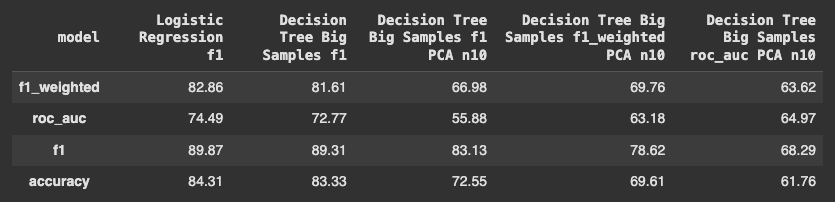

In [ ]:
for scoring in scoring_functions:
  for i in pca_components:
    param_grid = get_decisiontree_grid()
    model = DecisionTreeClassifier(random_state=42)
    ispca = True
    n_components = i

    my_X_train = df_train_scaled.copy()
    my_X_test = df_test_scaled.copy()
    my_y_train = y_train
    my_y_test = y_test

    best_model, my_X_train, my_X_test, \
    my_y_train, my_y_test, best_params,  = train_model(model,
                                            my_X_train, my_y_train,
                                            my_X_test, my_y_test,
                                            param_grid, ispca,
                                            n_components, scoring)

    evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                  best_params, preprocessor,
                  f'Decision Tree Big Samples {scoring} PCA n{i}')

  #true negatives 0,0     false positives 0, 1
  #false negatives 1,0    true positives 1,1for scoring in scoring_functions:


Components: 4
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 50}
-----Decision Tree Big Samples f1 PCA n4-----
Training Confusion Matrix:
 [[ 15 102]
 [  5 286]]
Testing Confusion Matrix:
 [[ 2 27]
 [ 7 66]]
Accuracy: Test 66.67  -  73.77 Train
ROC AUC: Test 48.65  -  55.55 Train
F1-score: 79.52  -  84.24 Train
Weighted F1-score: 59.9  -  66.36 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.13      0.22       117
         1.0       0.74      0.98      0.84       291

    accuracy                           0.74       408
   macro avg       0.74      0.56      0.53       408
weighted avg       0.74      0.74      0.66       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.22      0.07  

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                              'Decision Tree Big Samples f1',
                              'Decision Tree Big Samples f1 PCA n10',
                              'Decision Tree Big Samples f1_weighted PCA n10',
                              'Decision Tree Big Samples roc_auc PCA n10'])

df_summary

model       Logistic Regression f1 Decision Tree Big Samples f1  \
f1_weighted                  82.86                        81.61   
roc_auc                      74.49                        72.77   
f1                           89.87                        89.31   
accuracy                     84.31                        83.33   

model       Decision Tree Big Samples f1 PCA n10  \
f1_weighted                                66.98   
roc_auc                                    55.88   
f1                                         83.13   
accuracy                                   72.55   

model       Decision Tree Big Samples f1_weighted PCA n10  \
f1_weighted                                         69.76   
roc_auc                                             63.18   
f1                                                  78.62   
accuracy                                            69.61   

model       Decision Tree Big Samples roc_auc PCA n10  
f1_weighted                                     63.62  
roc_auc                                         64.97  
f1                                              68.29  
accuracy                                        61.76

## Decision Tree Small Samples PCA

When using small samples with PCA, the best models this time performed with `n_components = 7` for f1 and roc_auc, and `n_components = 10` for f1_weighted. All of them still performed much worse than Vanilla Decision Trees with Small Samples

The winning model for the f1 scoring variant is noteworthy because at `n_components` = 7, it had the highest f1_weighted score for test, but the lowest f1_weighted score for train.
- Weighted F1-score: 64.16  -  65.76 Train

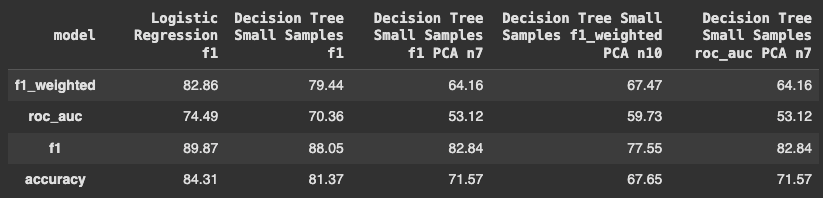

In [ ]:
for scoring in scoring_functions:
  for i in pca_components:
    param_grid = get_decisiontree_grid(True)
    model = DecisionTreeClassifier(random_state=42)
    ispca = True
    n_components = i

    my_X_train = df_train_scaled.copy()
    my_X_test = df_test_scaled.copy()
    my_y_train = y_train
    my_y_test = y_test

    best_model, my_X_train, my_X_test, \
    my_y_train, my_y_test, best_params,  = train_model(model,
                                            my_X_train, my_y_train,
                                            my_X_test, my_y_test,
                                            param_grid, ispca,
                                            n_components, scoring)

    evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                  best_params, preprocessor,
                  f'Decision Tree Small Samples {scoring} PCA n{i}')

  #true negatives 0,0     false positives 0, 1
  #false negatives 1,0    true positives 1,1for scoring in scoring_functions:


Components: 4
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
-----Decision Tree Small Samples f1 PCA n4-----
Training Confusion Matrix:
 [[ 27  90]
 [ 13 278]]
Testing Confusion Matrix:
 [[ 3 26]
 [ 6 67]]
Accuracy: Test 68.63  -  74.75 Train
ROC AUC: Test 51.06  -  59.3 Train
F1-score: 80.72  -  84.37 Train
Weighted F1-score: 62.26  -  70.04 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.23      0.34       117
         1.0       0.76      0.96      0.84       291

    accuracy                           0.75       408
   macro avg       0.72      0.59      0.59       408
weighted avg       0.73      0.75      0.70       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.33      0.10    

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                              'Decision Tree Small Samples f1',
                              'Decision Tree Small Samples f1 PCA n7',
                              'Decision Tree Small Samples f1_weighted PCA n10',
                              'Decision Tree Small Samples roc_auc PCA n7'])

df_summary

model       Logistic Regression f1 Decision Tree Small Samples f1  \
f1_weighted                  82.86                          79.44   
roc_auc                      74.49                          70.36   
f1                           89.87                          88.05   
accuracy                     84.31                          81.37   

model       Decision Tree Small Samples f1 PCA n7  \
f1_weighted                                 64.16   
roc_auc                                     53.12   
f1                                          82.84   
accuracy                                    71.57   

model       Decision Tree Small Samples f1_weighted PCA n10  \
f1_weighted                                           67.47   
roc_auc                                               59.73   
f1                                                    77.55   
accuracy                                              67.65   

model       Decision Tree Small Samples roc_auc PCA n7  
f1_weighted                                      64.16  
roc_auc                                          53.12  
f1                                               82.84  
accuracy                                         71.57

# WARNING: VERY SLOW - Random Forest

The Random Forest model training is very slow. Though I've prepared the code for PCA variants, I did not execute them.

## Vanilla Random Forest - Big Samples

Using big `min_samples`, the random forest algorithm using f1 scoring performed the best, and had the same scores as Vanilla SVM, but with a noticeably longer training runtime. They are still not as good as vanilla Logistic Regression.

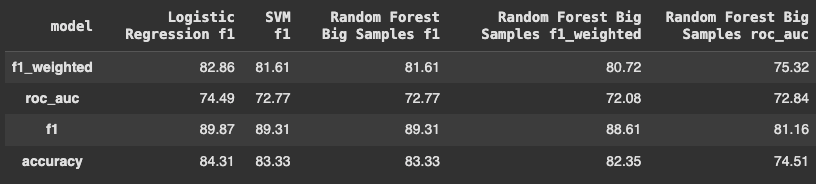

In [ ]:
for scoring in scoring_functions:

  model = RandomForestClassifier(random_state=42)
  param_grid = get_forest_grid()
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.copy()
  my_X_test = df_test_scaled.copy()
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                f'Random Forest Big Samples {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'class_weight': None, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 50}
-----Random Forest Big Samples f1-----
Training Confusion Matrix:
 [[ 42  75]
 [  5 286]]
Testing Confusion Matrix:
 [[14 15]
 [ 2 71]]
Accuracy: Test 83.33  -  80.39 Train
ROC AUC: Test 72.77  -  67.09 Train
F1-score: 89.31  -  87.73 Train
Weighted F1-score: 81.61  -  77.26 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.36      0.51       117
         1.0       0.79      0.98      0.88       291

    accuracy                           0.80       408
   macro avg       0.84      0.67      0.69       408
weighted avg       0.82      0.80      0.77       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.48      0.62        29
   

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                              'SVM f1',
                              'Random Forest Big Samples f1',
                              'Random Forest Big Samples f1_weighted',
                              'Random Forest Big Samples roc_auc'])

df_summary

model       Logistic Regression f1 SVM f1 Random Forest Big Samples f1  \
f1_weighted                  82.86  81.61                        81.61   
roc_auc                      74.49  72.77                        72.77   
f1                           89.87  89.31                        89.31   
accuracy                     84.31  83.33                        83.33   

model       Random Forest Big Samples f1_weighted  \
f1_weighted                                 80.72   
roc_auc                                     72.08   
f1                                          88.61   
accuracy                                    82.35   

model       Random Forest Big Samples roc_auc  
f1_weighted                             75.32  
roc_auc                                 72.84  
f1                                      81.16  
accuracy                                74.51

## Vanilla Random Forest - Small Samples

Using smaller min_samples with random forests performmed the same across the three scoring functions, and they have outperformed even the logistic regression classifier (f1_weighted by 0.32%, roc_auc by 1.24%) even though they has slightly lower f1 score (0.13% less)
- it means they were able to predict class 0 a little better, but class 1 slightly worse. Since dataset is imbalanced towards class 1, f1_weighted score for them becomes higher.

These variants are also the first ones where the training performance metrics are consistently better than the test performance metrics.

Even though they are now the best performing models of all, they take a very long time to train.


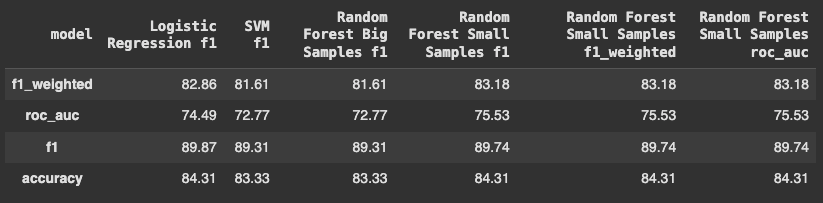

In [ ]:
for scoring in scoring_functions:

  model = RandomForestClassifier(random_state=42)
  param_grid = get_forest_grid(True)
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.copy()
  my_X_test = df_test_scaled.copy()
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                 f'Random Forest Small Samples {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
-----Random Forest Small Samples f1-----
Training Confusion Matrix:
 [[ 71  46]
 [  5 286]]
Testing Confusion Matrix:
 [[16 13]
 [ 3 70]]
Accuracy: Test 84.31  -  87.5 Train
ROC AUC: Test 75.53  -  79.48 Train
F1-score: 89.74  -  91.81 Train
Weighted F1-score: 83.18  -  86.58 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.61      0.74       117
         1.0       0.86      0.98      0.92       291

    accuracy                           0.88       408
   macro avg       0.90      0.79      0.83       408
weighted avg       0.88      0.88      0.87       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.55      0.67        29

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                              'SVM f1',
                              'Random Forest Big Samples f1',
                              'Random Forest Small Samples f1',
                              'Random Forest Small Samples f1_weighted',
                              'Random Forest Small Samples roc_auc'])

df_summary

model       Logistic Regression f1 SVM f1 Random Forest Big Samples f1  \
f1_weighted                  82.86  81.61                        81.61   
roc_auc                      74.49  72.77                        72.77   
f1                           89.87  89.31                        89.31   
accuracy                     84.31  83.33                        83.33   

model       Random Forest Small Samples f1  \
f1_weighted                          83.18   
roc_auc                              75.53   
f1                                   89.74   
accuracy                             84.31   

model       Random Forest Small Samples f1_weighted  \
f1_weighted                                   83.18   
roc_auc                                       75.53   
f1                                            89.74   
accuracy                                      84.31   

model       Random Forest Small Samples roc_auc  
f1_weighted                               83.18  
roc_auc                                   75.53  
f1                                        89.74  
accuracy                                  84.31

## Random Forest Minus Dependents - Big Samples

After removing the `dependents` feature, the best performing model were the f1 and f1_weighted variants, which had the exact same performance metrics as Vanilla SVM and Vanilla Random Forests with Big Samples using f1-scoring

Using roc_auc as a scoring function had a big negative impact on the model's performance.

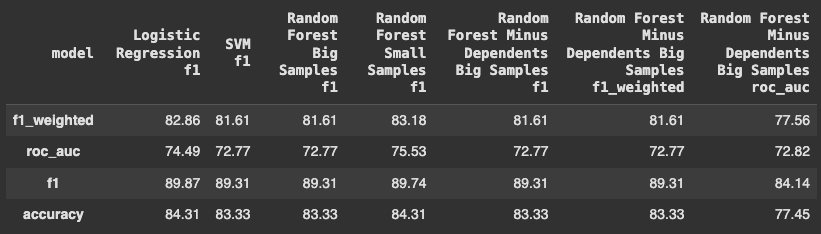

In [ ]:
for scoring in scoring_functions:

  model = RandomForestClassifier(random_state=42)
  param_grid = get_forest_grid()
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['cat_ord__dependents'], axis=1)
  my_X_test = df_test_scaled.drop(['cat_ord__dependents'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                f'Random Forest Minus Dependents Big Samples {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 100}
-----Random Forest Minus Dependents Big Samples f1-----
Training Confusion Matrix:
 [[ 40  77]
 [  5 286]]
Testing Confusion Matrix:
 [[14 15]
 [ 2 71]]
Accuracy: Test 83.33  -  79.9 Train
ROC AUC: Test 72.77  -  66.23 Train
F1-score: 89.31  -  87.46 Train
Weighted F1-score: 81.61  -  76.54 Train
Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.34      0.49       117
         1.0       0.79      0.98      0.87       291

    accuracy                           0.80       408
   macro avg       0.84      0.66      0.68       408
weighted avg       0.82      0.80      0.77       408

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.48   

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                              'SVM f1',
                              'Random Forest Big Samples f1',
                              'Random Forest Small Samples f1',
                              'Random Forest Minus Dependents Big Samples f1',
                              'Random Forest Minus Dependents Big Samples f1_weighted',
                              'Random Forest Minus Dependents Big Samples roc_auc'])

df_summary

model       Logistic Regression f1 SVM f1 Random Forest Big Samples f1  \
f1_weighted                  82.86  81.61                        81.61   
roc_auc                      74.49  72.77                        72.77   
f1                           89.87  89.31                        89.31   
accuracy                     84.31  83.33                        83.33   

model       Random Forest Small Samples f1  \
f1_weighted                          83.18   
roc_auc                              75.53   
f1                                   89.74   
accuracy                             84.31   

model       Random Forest Minus Dependents Big Samples f1  \
f1_weighted                                         81.61   
roc_auc                                             72.77   
f1                                                  89.31   
accuracy                                            83.33   

model       Random Forest Minus Dependents Big Samples f1_weighted  \
f1_weighted                                              81.61       
roc_auc                                                  72.77       
f1                                                       89.31       
accuracy                                                 83.33       

model       Random Forest Minus Dependents Big Samples roc_auc  
f1_weighted                                              77.56  
roc_auc                                                  72.82  
f1                                                       84.14  
accuracy                                                 77.45

## Random Forest Minus Dependents - Small Samples

Using small samples with roc_auc scoring after removing `dependents` makes a model that performs the best among its counterparts, and is tied with Vanilla Random Forest with Small Samples using F1-score for first place based our chosen metrics (f1_weighted and then roc_auc).

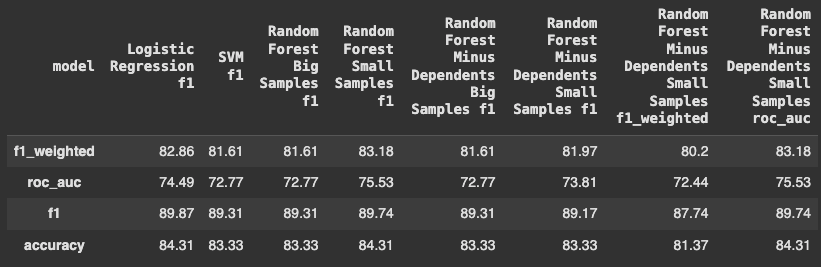

In [ ]:
for scoring in scoring_functions:
  model = RandomForestClassifier(random_state=42)
  param_grid = get_forest_grid(True)
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['cat_ord__dependents'], axis=1)
  my_X_test = df_test_scaled.drop(['cat_ord__dependents'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                f'Random Forest Minus Dependents Small Samples {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                              'SVM f1',
                              'Random Forest Big Samples f1',
                              'Random Forest Small Samples f1',
                              'Random Forest Minus Dependents Big Samples f1',
                              'Random Forest Minus Dependents Small Samples f1',
                              'Random Forest Minus Dependents Small Samples f1_weighted',
                              'Random Forest Minus Dependents Small Samples roc_auc'])

df_summary

## Random Forest Big Samples PCA

In [ ]:
'''
for scoring in scoring_functions:
  for i in pca_components:
    param_grid = get_decisiontree_grid()
    model = RandomForestClassifier(random_state=42)
    ispca = True
    n_components = i

    my_X_train = df_train_scaled.copy()
    my_X_test = df_test_scaled.copy()
    my_y_train = y_train
    my_y_test = y_test

    best_model, my_X_train, my_X_test, \
    my_y_train, my_y_test, best_params,  = train_model(model,
                                            my_X_train, my_y_train,
                                            my_X_test, my_y_test,
                                            param_grid, ispca,
                                            n_components, scoring)

    evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                  best_params, preprocessor,
                    f'Random Forest Big Samples {scoring} PCA n{i}')

  #true negatives 0,0     false positives 0, 1
  #false negatives 1,0    true positives 1,1for scoring in scoring_functions:
'''

## Random Forest Small Samples PCA

In [ ]:
'''
for scoring in scoring_functions:
  for i in pca_components:
    param_grid = get_decisiontree_grid(True)
    model = RandomForestClassifier(random_state=42)
    ispca = True
    n_components = i

    my_X_train = df_train_scaled.copy()
    my_X_test = df_test_scaled.copy()
    my_y_train = y_train
    my_y_test = y_test

    best_model, my_X_train, my_X_test, \
    my_y_train, my_y_test, best_params,  = train_model(model,
                                            my_X_train, my_y_train,
                                            my_X_test, my_y_test,
                                            param_grid, ispca,
                                            n_components, scoring)

    evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                  best_params, preprocessor,
                  f'Random Forest Small Samples {scoring} PCA n{i}')

  #true negatives 0,0     false positives 0, 1
  #false negatives 1,0    true positives 1,1for scoring in scoring_functions:
  '''

# Model Ranking

In [ ]:
df_models = pd.DataFrame.from_dict(model_comparisons, orient='index')
df_models = df_models[['f1_weighted', 'roc_auc', 'f1', 'accuracy' ]]
df_models = df_models.reset_index()
df_models.rename(columns={'index': 'model'}, inplace=True)

df_models = df_models.sort_values(by=['f1_weighted',
                                      'roc_auc',
                                      'f1',
                                      'accuracy'],
                                  ascending=[False,
                                             False,
                                             False,
                                             False]).reset_index(drop=True)
df_models.head(25)


# New Data Prediction

To make predictions:

1. Run everything from "helper functions" and above under Machine Learning Setup.
2. Train your desired machine learning variant so that its model is stored in the model_comparisons dictionary. Take note of the model key.
3. Load new data for prediction.
4. As long as the new data has the same properties and format as the training data, clean it using clean_data(df) below.
5. Use the model key and your cleaned data to make_predictions or make_probability_predictions.

In [ ]:
def clean_data (df, for_treee=False,
                minus_dependents=False,
                minus_loan_amount=False):
  # drop ID
  df = df.iloc[:, 1:]

  #clean the dependents
  df = clean_dependents(df)

  X_scaled = preprocessor.transform(df)
  df_scaled= pd.DataFrame(X_scaled, columns=preprocessor.get_feature_names_out())
  if (not for_tree):
    df_scaled= df_scaled.drop(['cat_onehot__property_area_Rural'], axis=1)

  if(minus_dependents):
    df_scaled= df_scaled.drop(['cat_ord__dependents'], axis=1)

  if(minus_loan_amount):
    df_scaled= df_scaled.drop(['num__loan_amount'], axis=1)


  # if doing PCA, use PCA.fit() with n_components on df_train_scaled, random_state=42
  # end then use pca.transform on df_scaled
  return df_scaled


In [ ]:
def make_prediction(model_name, data):
  model =  model_comparisons[model_name]['model']
  prediction = model.predict(data)

  return prediction

In [ ]:
def make_probability_prediction(model_name, data):
  model =  model_comparisons[model_name]['model']
  probability_prediction = model.predict_proba(data)

  #predict_proba returns 2D array
  #1st dimension rows, corresponding to each data point fed
  #2nd dimension: [0] = probability that row is class 0
  #               [1] = probability that row is class 1

  return probability_prediction

## Simulate new data by just redownloading the dataset

In [ ]:
#https://drive.google.com/file/d/1yBwpPsPsp1AZGDv_VdGSv1Lov2RwtbN2/view

file_id = "1yBwpPsPsp1AZGDv_VdGSv1Lov2RwtbN2"
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

response = requests.get(download_url)
if response.status_code == 200:
    csv_data = StringIO(response.text)
    df_new_data = pd.read_csv(csv_data)
    print(df.head())
else:
    print("Failed to download the file.")

## Test Cleaning The Data

In [ ]:
X = clean_data(df_new_data, False, False)
print (X.head())
X.info()

## Make batch comparison

In [ ]:
new_data_X = df_new_data[(~df_new_data['loan_status'].isnull())]
for_tree = False
minus_dependents = False
minus_loan_amount = False
new_data_X = clean_data(new_data_X, for_tree, minus_dependents,
                        minus_loan_amount)
new_data_y = df_new_data['loan_status'][(~df_new_data['loan_status'].isnull())]


prediction = make_prediction('Logistic Regression f1', new_data_X)

accuracy = round(accuracy_score(new_data_y, prediction)*100, 2)
conf_matrix = confusion_matrix(new_data_y, prediction)
class_report = classification_report(new_data_y, prediction)
roc_auc = round(roc_auc_score(new_data_y, prediction)*100, 2)
f1 = round(f1_score(new_data_y, prediction)*100, 2)
f1_weighted = round(f1_score(new_data_y, prediction, average='weighted')*100, 2)

# Printing evaluation metrics
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("F1-score:", f1)
print("Weighted F1-score:", f1_weighted)
print("Classification Report:\n", class_report)

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

## Make Row by Row Prediction

In [ ]:
#try making predictions for the original items without labels
new_data_X = df_new_data.drop(['loan_status'], axis=1)[(df_new_data['loan_status'].isnull())]
for_tree = False
minus_dependents = False
minus_loan_amount = False
new_data_X = clean_data(new_data_X, for_tree, minus_dependents,
                        minus_loan_amount)

prediction = make_prediction('Logistic Regression Minus Dependents f1', new_data_X)

for row in prediction:
  if row == 1:
    print("Likely Approved")
  else:
    print("Likely Denied")

In [ ]:
#try making predictions for the original items without labels
new_data_X = df_new_data.drop(['loan_status'], axis=1)[(df_new_data['loan_status'].isnull())]
for_tree = False
minus_dependents = False
minus_loan_amount = False
new_data_X = clean_data(new_data_X, for_tree, minus_dependents,
                        minus_loan_amount)

prediction = make_probability_prediction('Decision Tree Small Samples Minus Dependents f1',
                             new_data_X)

#prediction = make_probability_prediction('Logistic Regression Minus Dependents f1',
#                             new_data_X)


print(prediction)


for row in prediction:
  if row[1] > 0.6:
    print("Likely Approved")
  else:
    print("Likely Denied")

# BONUS TESTS: Removing loan_amount

SVM Minus Loan Amount using roc_auc as the scoring function has jumped to first place, on f1_weighted score.

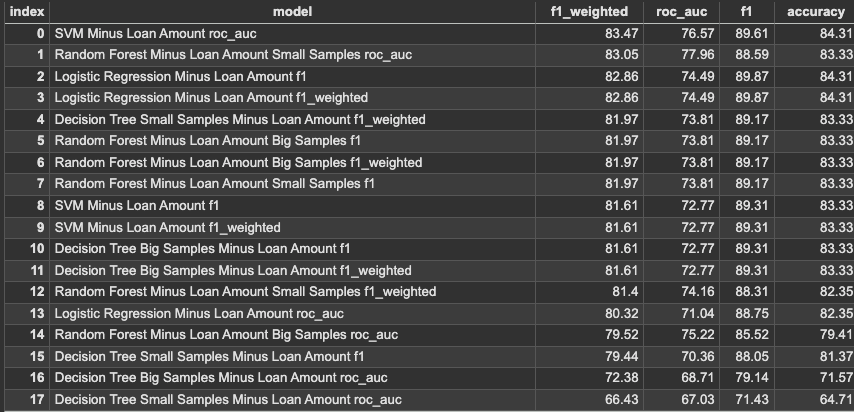

## Logistic Regression Minus Loan Amount

In [ ]:
# Best Hyperparameters:
# {'C': 1}
for scoring in scoring_functions:
  model = LogisticRegression(max_iter=10000, random_state=42,)
  #1000 fails to converge
  param_grid = get_logreg_grid()
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['num__loan_amount'], axis=1)
  my_X_test = df_test_scaled.drop(['num__loan_amount'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
               f'Logistic Regression Minus Loan Amount {scoring}')


#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

## SVM Minus Loan Amount

In [ ]:
for scoring in scoring_functions:
  model = SVC(random_state=42)
  param_grid = get_svm_grid()
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['num__loan_amount'], axis=1)
  my_X_test = df_test_scaled.drop(['num__loan_amount'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                 f'SVM Minus Loan Amount {scoring}')


## Decision Tree Minus Loan Amount - Big Samples

In [ ]:
for scoring in scoring_functions:
  model = DecisionTreeClassifier(random_state=42)
  param_grid = get_decisiontree_grid()
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['num__loan_amount'], axis=1)
  my_X_test = df_test_scaled.drop(['num__loan_amount'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                 f'Decision Tree Big Samples Minus Loan Amount {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

## Decision Tree Minus Loan Amount - Small Samples

In [ ]:
for scoring in scoring_functions:
  model = DecisionTreeClassifier(random_state=42)
  param_grid = get_decisiontree_grid(True)
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['num__loan_amount'], axis=1)
  my_X_test = df_test_scaled.drop(['num__loan_amount'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                 f'Decision Tree Small Samples Minus Loan Amount {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

## Random Forest Minus Loan Amount - Big Samples

In [ ]:
for scoring in scoring_functions:
  model = RandomForestClassifier(random_state=42)
  param_grid = get_forest_grid()
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['num__loan_amount'], axis=1)
  my_X_test = df_test_scaled.drop(['num__loan_amount'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                 f'Random Forest Minus Loan Amount Big Samples {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

## Random Forest Minus Loan Amount - Small Samples

In [ ]:
for scoring in scoring_functions:
  model = RandomForestClassifier(random_state=42)
  param_grid = get_forest_grid(True)
  ispca = False
  n_components = 0

  my_X_train = df_train_scaled.drop(['num__loan_amount'], axis=1)
  my_X_test = df_test_scaled.drop(['num__loan_amount'], axis=1)
  my_y_train = y_train
  my_y_test = y_test

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(model,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, preprocessor,
                 f'Random Forest Minus Loan Amount Small Samples {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

## Model Rankings 2

In [ ]:
df_models = pd.DataFrame.from_dict(model_comparisons, orient='index')
df_models = df_models[['f1_weighted', 'roc_auc', 'f1', 'accuracy' ]]
df_models = df_models.reset_index()
df_models.rename(columns={'index': 'model'}, inplace=True)

df_models = df_models.loc[df_models['model'].str.contains('Loan Amount',
                                                       regex=False)]

df_models = df_models.sort_values(by=['f1_weighted',
                                      'roc_auc',
                                      'f1',
                                      'accuracy'],
                                  ascending=[False,
                                             False,
                                             False,
                                             False]).reset_index(drop=True)
df_models.head(25)


SVM Minus Loan Amount using roc_auc as the scoring function has jumped to first place, on f1_weighted score.

### Original Rankings for Comparison

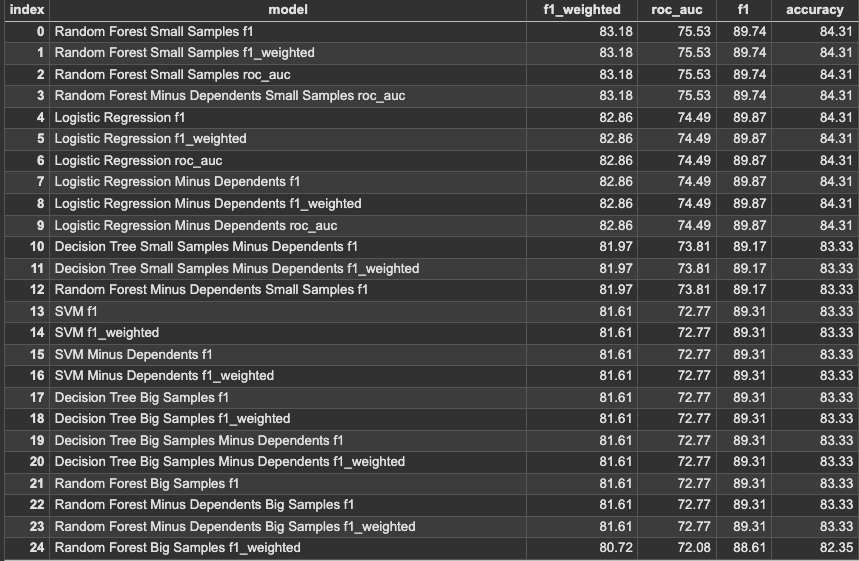